# 1 Data cleaning<a id='1_Data_cleaning'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Data cleaning](#1_Data_cleaning)
  * [1.1 Contents](#1.1_Contents)
  * [1.2 Introduction](#1.2_Introduction)
    * [1.2.1 Recap Of Data Science Problem](#1.2.1_Recap_Of_Data_Science_Problem)
    * [1.2.2 Introduction To Notebook](#1.2.2_Introduction_To_Notebook)
  * [1.3 Objectives](#1.3_Objectives)
  * [1.4 Imports](#1.4_Imports)
  * [1.5 Load Data](#1.5_Load_Data)
    * [1.5.1 Meter Readings](#1.5.1_Meter_Readings)
    * [1.5.2 Building Characteristics](#1.5.2_Building_Characteristics)
    * [1.5.3 Weather Data](#1.5.3_Weather_Data)
    * [1.5.4 Find Duplicates](#1.5.4_Find_Duplicates)
      * [1.5.4.1 Duplicates in Weather Data](#1.5.4.1_Duplicates_in_Weather_Data)
        * site id's 8 and 11 are duplicates
      * [1.5.4.2 Duplicates in Building Metadata](#1.5.4.2_Duplicates_in_Building_Metadata)    
    * [1.5.5 Number Of Missing Values](#1.5.4_Number_Of_Missing_Values)
    
        * floor_count is missing 75% of the data

        * The year_built, and cloud_coverage are missing about 50% of the values.

        * precip_depth_1_hr is missing 40% of the values.
       
  * [1.6 Exploration of the Data](#1.6_Exploration_of_the_Data)
    * [1.6.1 Categorical Features](#1.6.1_Categorical_Features)
      * [1.6.1.1 Building Primary Use](#1.6.1.1_Building_Primary_Use)
      
        * The primary use of most buildings are:
          * education
          * office
          * entertainment/public assembly
          * public services 
          * lodging/residential.
    
      * [1.6.1.2 Site ID](#1.6.1.2_Site_ID)
      
        * Sites 3 and 13 have the greatest percentages of the buildings.
        
      * [1.6.1.3 Meters](#1.6.1.3_Meters)
        * all building types have mostly electricity meter readings.
        * Warehouse/Storage and Services don't have any chilled water meter readings.
        * 'Other', Parking, Warehouse/Storage, Manufacturing/industrial, Retail, Services, Utility, and Religious worship don't have any hot water meter readings
        * Retail and Religious worship don't have any steam meter readings.
    * [1.6.2 Numeric Features](#1.6.2_Numeric_Features)
      * [1.6.2.1 Numeric Data Summary](#1.6.2.1_Numeric_Data_Summary)
      * [1.6.2.2 Numeric Data Distribution](#1.6.2.2_Numeric_Data_Distribution)
  * [1.7 Identifying Potential Outliers](#1.7_Identifying_Potential_Outliers)
      * [1.7.1 Potential Outliers in meter_reading](#1.7.1_Potential_Outliers_in_meter_reading)
      * [1.7.2 Potential Outliers in precip_depth_1_hr](#1.7.2_Potential_Outliers_in_precip_depth_1_hr)
  * [1.8 Aligning Time Zones](#1.8_Aligning_Time_Zones)
      * [1.8.1 Merging the data](#1.8.1_Merging_the_data)
      * [1.8.2 Energy usage vs. air temperature](#1.8.2_Energy_usage_vs_air_temperature)
      * [1.8.3 Use external temperature data to shift time zones](#1.8.3_Use_external_temperature_data_to_shift_time_zones)
  * [1.9 Saving_Processed_Data](#1.9_Saving_Processed_Data)


## 1.2 Introduction<a id='1.2_Introduction'></a>

### 1.2.1 Recap Of Data Science Problem<a id='1.2.1_Recap_Of_Data_Science_Problem'></a>

The goal of this project is to predict the building energy baseline for the year 2016.

### 1.2.2 Introduction To Notebook<a id='1.2.2_Introduction_To_Notebook'></a>

The datasets are the following:
* meter readings with energy use in kWh per hour for the year 2016. This dataset contains the building ID, the meter type (e.g., chilled water, electricity, steam, and hot water), and the meter reading.
* Details about each building. This includes the primary use of the building (e.g., education, office, etc.), number of floors, square footage, year it was built, and a site ID that links to weather data
* Weather data. This includes precipitation, cloud coverage, air temperature, dew temperature, sea level pressure, and wind direction and speed.

## 1.3 Objectives<a id='1.3_Objectives'></a>

* Identify null values and outliers
* Explore the distribution of the data
* Assess what data is worth keeping, replacing, or removing

## 1.4 Imports<a id='1.4_Imports'></a>

In [1]:
#Import pandas, matplotlib.pyplot, and seaborn in the correct lines below
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from random import sample

## 1.5 Load Data<a id='1.5_Load_Data'></a>

In [2]:
# the supplied CSV data files are in the data/raw directory
meter_data = pd.read_csv('../data/raw/train.csv')
building_metadata=pd.read_csv('../data/raw/building_metadata.csv')
weather_data=pd.read_csv('../data/raw/weather_train.csv')

### 1.5.1 Meter Readings<a id='1.5.1_Meter_Readings'></a>

In [3]:
#Call the info method on energy_data to see a summary of the data
meter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [4]:
meter_data.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In this data, we have a building ID, a meter ID, a timestamp, and the recorded meter reading. 

The timestamp goes from January 1st, 2016, to December 31st, 2016

The meter ID corresponds to 0: electricity, [1: chilled water, 2: steam, 3: hot water](https://www1.eere.energy.gov/buildings/publications/pdfs/commercial_initiative/hvac_volume1_final_report.pdf)

Is there data for all days and hours of the year? This is 2016, and has 366 days. 366*24 = 8784.

In [5]:
meter_data.timestamp.unique().shape

(8784,)

### 1.5.2 Building Characteristics<a id='1.5.2_Building_Characteristics'></a>

In [6]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [7]:
building_metadata.head(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In this dataset, we have 1449 different buildings. 

The site ID is a foreign key for the weather data.

We have building ID with its characteristics, which are:
* Its primary use
* Its size in square feet
* The year it was built 
* The number of floors it has

Notes relevant for cleaning:
* year_built and floor_count only have 675 and 355 non-null values out of the 1449 entries
* The dtypes of year_built and floor_count are float, when they should be integer 
    * tried to change the dtype, but the NaN values gave me errors

### 1.5.3 Weather Data<a id='1.5.3_Weather_Data'></a>

In [8]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Is there data for all days and hours of the year? This is 2016, and has 366 days. 366*24 = 8784.

In [9]:
weather_data.timestamp.unique().shape

(8784,)

In [10]:
weather_data.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


This dataset contains the site ID, which is linked to the site ID in the building metadata, the timestamp, and the weather details for that particular site and timestamp.

The weather features are:
* Air temperature
* Cloud coverage
* Dew temperature
* Precipitation depth in 1 hour
* Sea level pressure
* Wind direction
* Wind speed
    
The features with the most null values are cloud_coverage and precip_depth_1_hr. They seem to be missing nearly half of the values

### 1.5.4 Find Duplicates<a id='1.5.4_Find_Duplicates'></a>

#### 1.5.4.1 Duplicates in Weather Data<a id='1.5.4.1_Duplicates_in_Weather_Data'></a>

Find duplicates in the weather data:

In [11]:
duplicate_rows = weather_data[weather_data.duplicated(weather_data.drop('site_id',axis=1).columns,keep=False)]
duplicate_rows['site_id'].unique()

array([ 0,  7,  8, 11], dtype=int64)

Now that I have found these duplicates, I need to remove them from the weather data, and in the building_metadata, for those with site_id = 11 replace with 7, and those with site_id 8 replace with 0. How does this affect my data? type of buildings change in each site, just that distribution changes.

In [12]:
#What I want to do here is replace the site_id's with the correct numbers
building_metadata.replace({'site_id':{8:0,11:7}},inplace=True)

#next, check that rows with site_ids 8 and 11 don't exist 
building_metadata[(building_metadata['site_id']==8) | (building_metadata['site_id']==11)]

,site_id,building_id,primary_use,square_feet,year_built,floor_count


In [13]:
#What I want to do here is remove sites 8 and 11 from the weather data
weather_data=weather_data[(weather_data['site_id']!=8) & (weather_data['site_id']!=11)]

#next, check that these sites don't exist anymore in weather_data
weather_data[(weather_data['site_id']==8) | (weather_data['site_id']==11)]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed


#### 1.5.4.2 Duplicates in Building Metadata<a id='1.5.4.2_Duplicates_in_Building_Metadata'></a>

Find duplicates in the building_metadata

In [14]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [15]:
building_metadata[building_metadata.duplicated(building_metadata.drop('building_id',axis=1).columns,keep=False)].sort_values(by='square_feet')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
941,9,941,Lodging/residential,8079,NaN,NaN
940,9,940,Lodging/residential,8079,NaN,NaN
865,0,865,Public services,10174,NaN,1.0
866,0,866,Public services,10174,NaN,1.0
296,3,296,Public services,22000,NaN,NaN
310,3,310,Public services,22000,NaN,NaN
343,3,343,Public services,22000,NaN,NaN
67,0,67,Lodging/residential,24456,1968.0,NaN
49,0,49,Lodging/residential,24456,1968.0,NaN
100,0,100,Lodging/residential,24456,1968.0,NaN


Are these a coincidence? or real duplicates?

By visual inspection, the following buildings seem to repeat (plotting is shown below):
1. 940,941 - seem similar
2. 865,866 - seem similar
3. 296, 310, 343 - not the same
4. 67, 49, 100, 77 - seem similar
5. 85, 66 - seem similar 
6. 65, 64, (37, 36) - seem similar
7. 27, 90 - seem similar
8. 95 96 - not the same

A lot of these seem similar, but are not exactly the same... It could be that these buildings had multiple meters and those readings were recorded. Because this is only 21/1449 = 1.5% of the data, I don't expect this affecting the modeling too much, so the "possible duplicates" will be kept. 

To check for this, I will select the data in meter_data for these buildings, and check if the meter readings are also duplicates.

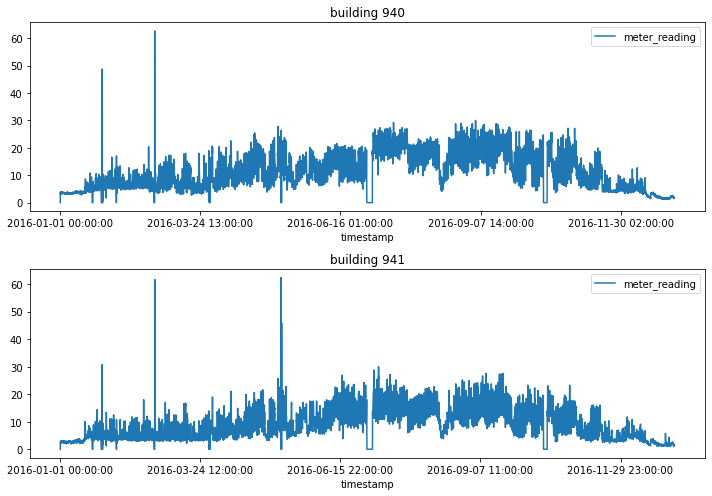

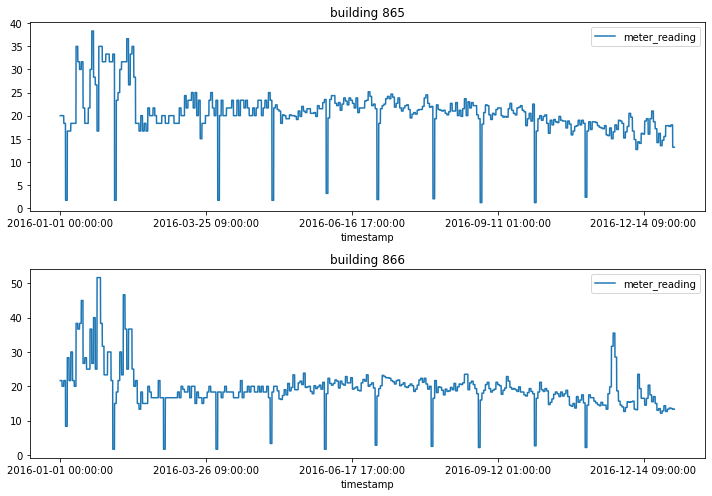

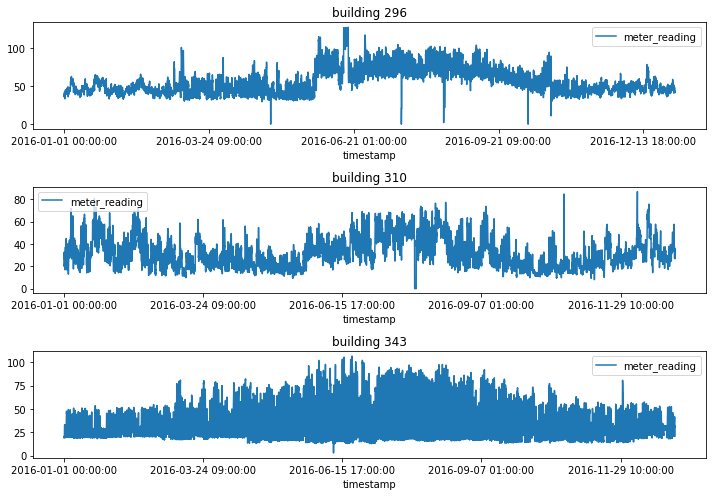

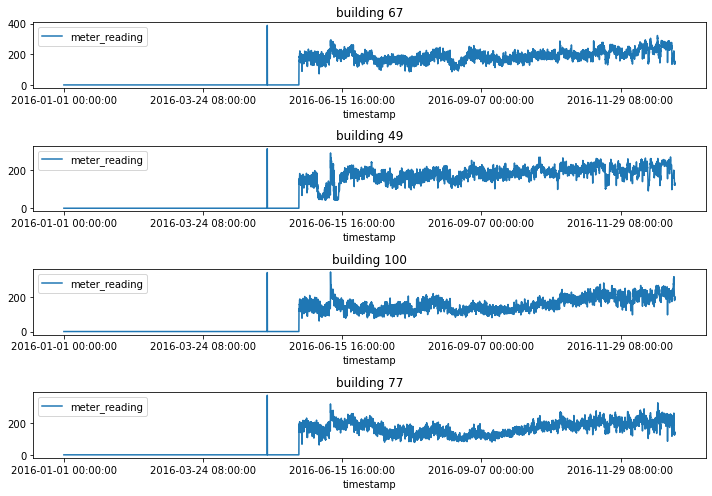

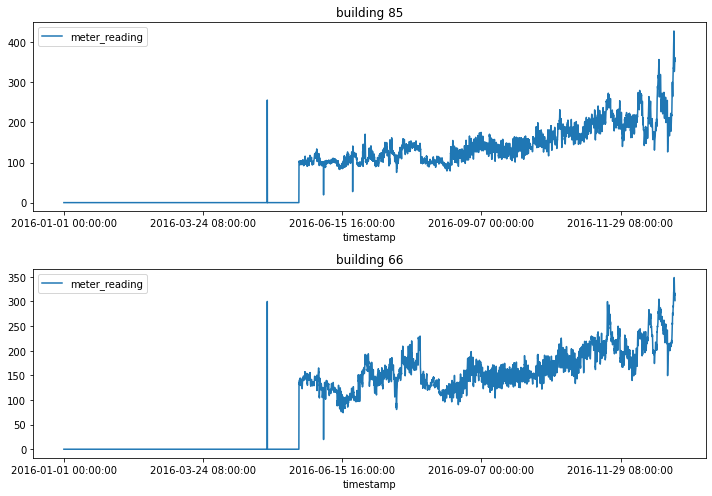

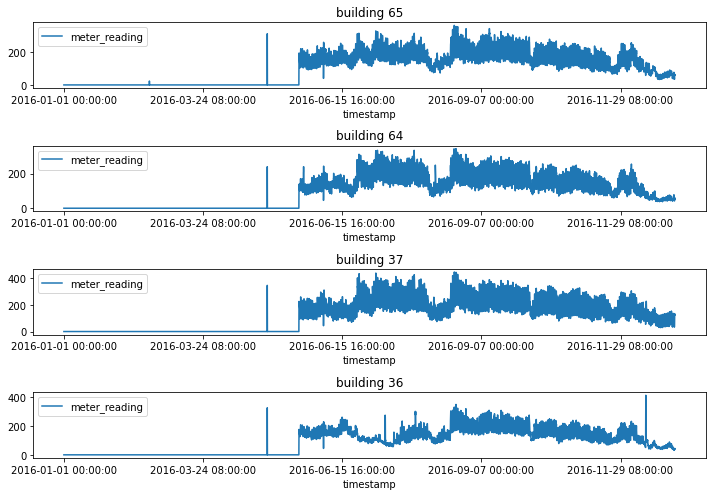

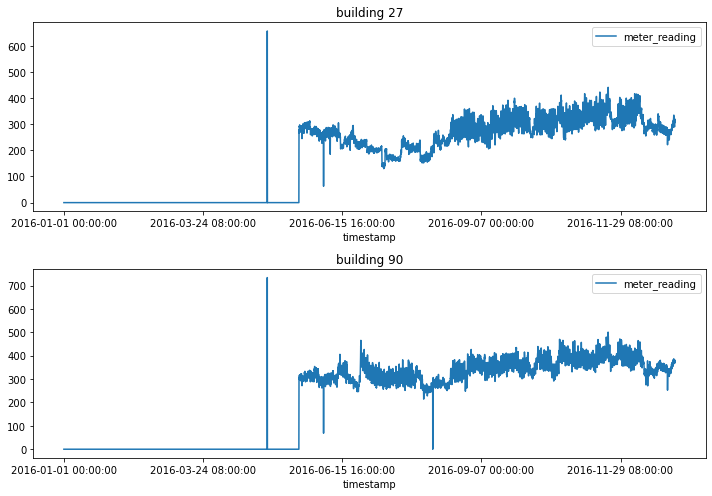

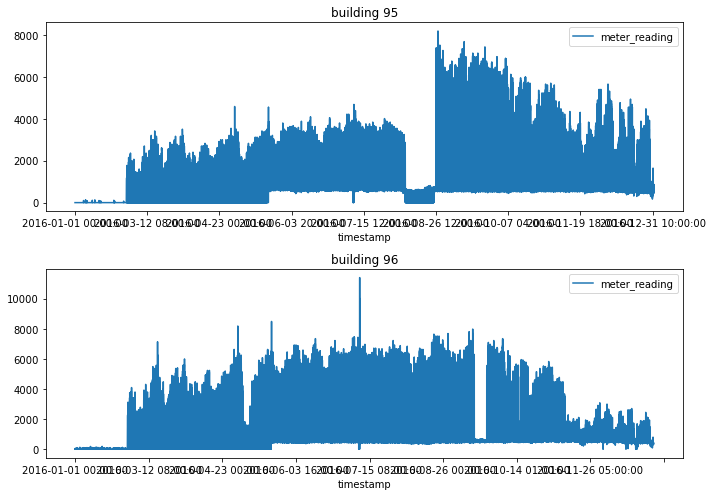

In [16]:
possible_dups=[[940,941],[865,866],[296,310,343],[67,49,100,77],[85,66],[65,64,37,36],[27,90],[95,96]]
for group in possible_dups:
    fig,ax=plt.subplots(len(group),1,figsize=(10,7))
    for i in range(len(group)):
        meter_data[meter_data['building_id']==group[i]].plot(x='timestamp',y='meter_reading',ax=ax[i])
        ax[i].set_title('building %s' %(str(group[i])))
        plt.tight_layout()

### 1.5.5 Number Of Missing Values<a id='1.5.4_Number_Of_Missing_Values'></a>

In [17]:
#In this cell, I will construct a Pandas DataFrame that shows the number and percentage of missing values by column in each dataset
meter_reading_missing=pd.concat([meter_data.isnull().sum(),100*meter_data.isnull().mean()], axis=1)
meter_reading_missing.columns=['Count','%']
meter_reading_missing=meter_reading_missing.sort_values(by='Count',ascending=False)
meter_reading_missing

,Count,%
building_id,0,0.0
meter,0,0.0
timestamp,0,0.0
meter_reading,0,0.0


In [18]:
building_metadata_missing=pd.concat([building_metadata.isnull().sum(),100*building_metadata.isnull().mean()], axis=1)
building_metadata_missing.columns=['Count','%']
building_metadata_missing=building_metadata_missing.sort_values(by='Count',ascending=False)
building_metadata_missing

,Count,%
floor_count,1094,75.500345
year_built,774,53.416149
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000


In [19]:
weather_data_missing=pd.concat([weather_data.isnull().sum(),100*weather_data.isnull().mean()], axis=1)
weather_data_missing.columns=['Count','%']
weather_data_missing=weather_data_missing.sort_values(by='Count',ascending=False)
weather_data_missing

,Count,%
cloud_coverage,56729,46.356691
precip_depth_1_hr,42405,34.651685
sea_level_pressure,10525,8.600613
wind_direction,6018,4.917671
wind_speed,304,0.248417
dew_temperature,87,0.071093
air_temperature,52,0.042492
site_id,0,0.000000
timestamp,0,0.000000


* Floor_count is missing 75% of the data
* The year_built, and cloud_coverage are missing about 50% of the values

* precip_depth_1_hr is missing 34% of the values

Another thing to note is that isnull() is not the only indicator of missing data. Sometimes 'missingness' can be encoded, perhaps by a -1 or 999. I may have to look for these values as well.

## 1.6 Exploration of the Data<a id='1.6_Exploration_of_the_Data'></a>

### 1.6.1 Categorical Features<a id='1.6.1_Categorical_Features'></a>

The categorical features in this dataset are the primary use of the building, the meter type, and the site ID.

Here I will explore the distribution of the primary use of the building. In the future, I will be interested in seeing the amount of energy use for each type of building. As a reminder, there are no missing values for the primary_use column.

#### 1.6.1.1 Building Primary Use<a id='1.6.1.1_Building_Primary_Use'></a>

In [20]:
#select unique values
#building_metadata['primary_use'].value_counts()
#calculate the percentage of each type out of all buildings in this dataset
#100*building_metadata['primary_use'].value_counts()/len(building_metadata)
#Put the counts and percentages in the same df
primary_use_df=pd.concat([building_metadata['primary_use'].value_counts(),
                           100*building_metadata['primary_use'].value_counts()/len(building_metadata)],axis=1)
primary_use_df.columns=['Count','%']
primary_use_df.sort_values(by='Count',ascending=False)
primary_use_df=primary_use_df.reset_index()
primary_use_df = primary_use_df.rename(columns={'index': 'primary_use'})
primary_use_df

,primary_use,Count,%
0,Education,549,37.888199
1,Office,279,19.254658
2,Entertainment/public assembly,184,12.698413
3,Public services,156,10.766046
4,Lodging/residential,147,10.144928
5,Other,25,1.725328
6,Healthcare,23,1.587302
7,Parking,22,1.518288
8,Warehouse/storage,13,0.897170
9,Manufacturing/industrial,12,0.828157


The primary use of most buildings are education, office, entertainment/public assembly, public services, and lodging/residential.

Something that will be interesting here is to find the energy use of each type of building and what kinds of meters each type of building has, and how their energy use varies for each building type.

Text(0.5, 0, 'Count')

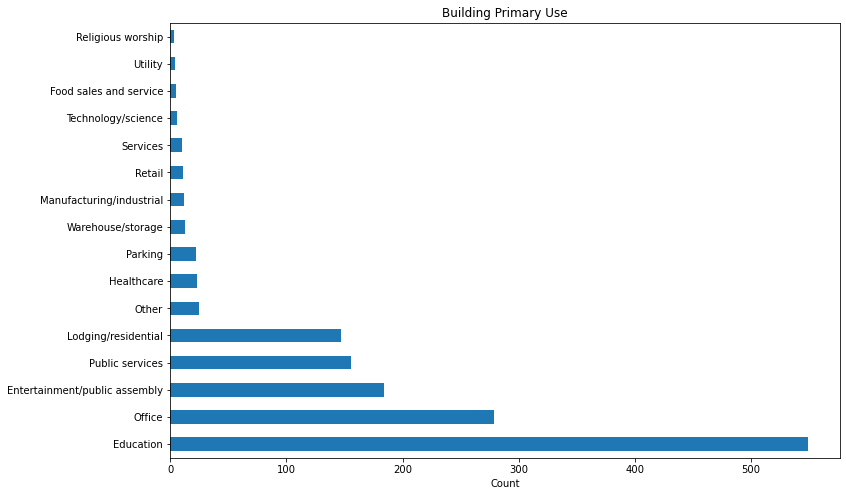

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
building_metadata['primary_use'].value_counts().plot(kind='barh', ax=ax)
ax.set_title('Building Primary Use')
ax.set_xlabel('Count')

#### 1.6.1.2 Site ID<a id='1.6.1.2_Site_ID'></a>

In [22]:
site_id_df=pd.concat([building_metadata['site_id'].value_counts(),
                           100*building_metadata['site_id'].value_counts()/len(building_metadata)],axis=1)
site_id_df.columns=['Count','%']
site_id_df.sort_values(by='Count',ascending=False)
site_id_df

,Count,%
3,274,18.909593
0,175,12.077295
13,154,10.628019
2,135,9.316770
9,124,8.557626
15,124,8.557626
14,102,7.039337
4,91,6.280193
5,89,6.142167
1,51,3.519669


Sites 3 and 13 have the greatest percentages of the buildings.

What will be interesting to think about in the future are more details about the site ID. Its weather? Distribution of types of buildings? The energy use?

Text(0.5, 0, 'Count')

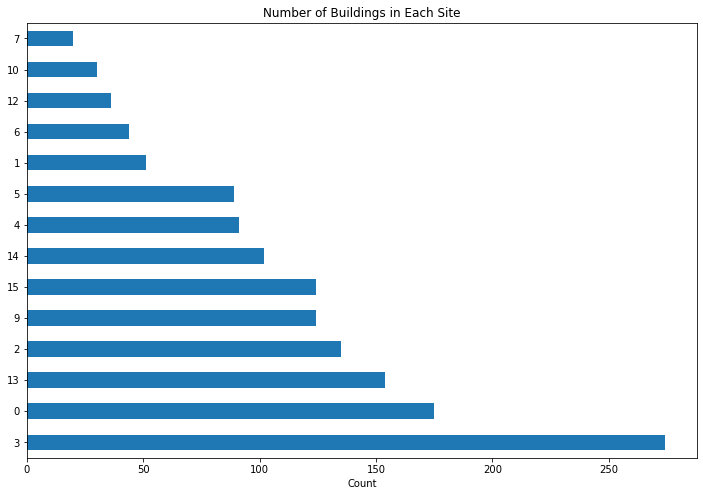

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
building_metadata['site_id'].value_counts().plot(kind='barh', ax=ax)
ax.set_title('Number of Buildings in Each Site')
ax.set_xlabel('Count')

#### 1.6.1.3 Meters<a id='1.6.1.3_Meters'></a>

How many of each meter does each type of building have? This is interesting to answer because the buildings can be different in the kind of energy that they consume

To answer this question, I have to merge the building_metadata and the meter_data

In [24]:
building_meter_data=meter_data.merge(building_metadata,on='building_id')
building_meter_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN


In [25]:
#After merging, here I replace the 0, 1, 2, and 3 values under meter with their corresponding meter types. 
#From there, I create new columns from the strings under meter and give them 1/0 values, 
#so that I can group by building type and get the percentage of each meter type for all meter readings. 
#I also merge to this dataset to the distribution by counts and percentage of building type, 
#so I can sort the final dataset by primary_use %.
building_meter_data['meter'] = building_meter_data['meter'].map({0:'electricity', 1:'chilled_water',\
                                                                 2:'steam',3:'hot_water'}) 
dummy_meter = pd.get_dummies(building_meter_data['meter'], prefix='meter')
building_meter_data = pd.merge(left=building_meter_data,right=dummy_meter,left_index=True,right_index=True)

primary_use_meters=building_meter_data.groupby('primary_use')[['meter_chilled_water',\
                                                               'meter_electricity','meter_hot_water',\
                                                               'meter_steam']].mean()*100
primary_use_meters=primary_use_meters.merge(primary_use_df,on='primary_use')
primary_use_meters=primary_use_meters.sort_values(by='%',ascending=False,ignore_index=True)
primary_use_meters.head()

,primary_use,meter_chilled_water,meter_electricity,meter_hot_water,meter_steam,Count,%
0,Education,22.327158,56.300946,7.453355,13.918541,549,37.888199
1,Office,25.418284,52.565972,6.591558,15.424186,279,19.254658
2,Entertainment/public assembly,16.409564,66.726286,6.145391,10.718759,184,12.698413
3,Public services,10.817548,79.385636,4.752271,5.044545,156,10.766046
4,Lodging/residential,21.330145,57.262139,4.465590,16.942126,147,10.144928


Text(0.5, 0, 'building type')

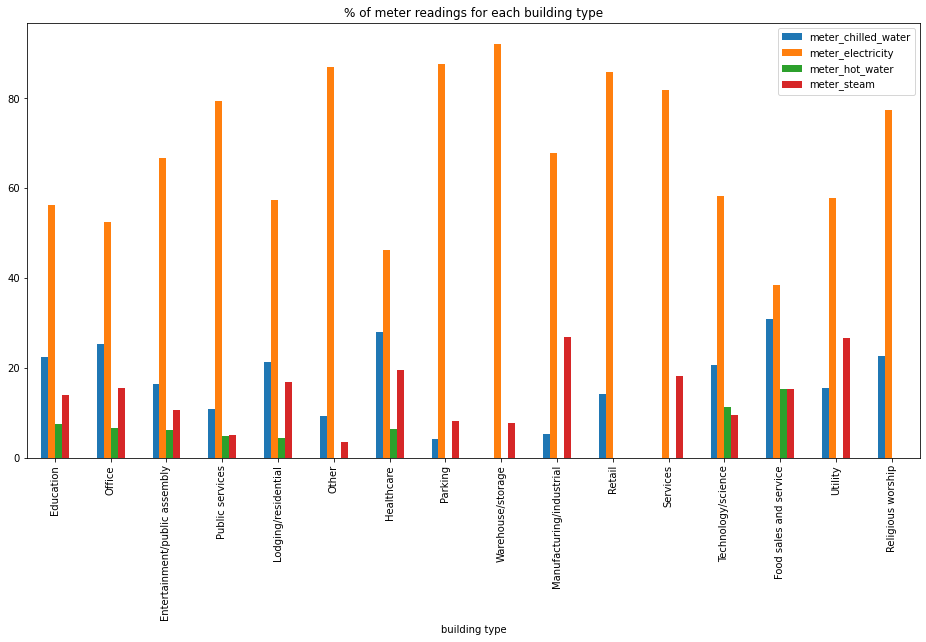

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
primary_use_meters.plot(x="primary_use", y=['meter_chilled_water','meter_electricity','meter_hot_water','meter_steam'], kind="bar", ax=ax)
ax.set_title('% of meter readings for each building type')
ax.set_xlabel('building type')

From the bargraph above we see that:
* all building types have mostly electricity meter readings. 
* Warehouse/Storage and Services don't have any chilled water meter readings. 
* 'Other', Parking, Warehouse/Storage, Manufacturing/industrial, Retail, Services, Utility, and Religious worship don't have any hot water meter readings 
* Retail and Religious worship don't have any steam meter readings. 

### 1.6.2 Numeric Features<a id='1.6.2_Numeric_Features'></a>

#### 1.6.2.1 Numeric Data Summary<a id='1.6.2.1_Numeric_Data_Summary'></a>

Before looking at the meter data, I will have to fix the electricity readings. According to the information in the kaggle competition, the unit for the electricity measurement is kBTU. So, to convert to kWh, I have to multiply by 0.2931. 

In [27]:
meter_data[meter_data['meter']==1].head()

,building_id,meter,timestamp,meter_reading
172,161,1,2016-01-01 00:00:00,0.0000
174,162,1,2016-01-01 00:00:00,0.0000
176,163,1,2016-01-01 00:00:00,4.5719
181,166,1,2016-01-01 00:00:00,209.8860
184,167,1,2016-01-01 00:00:00,0.0000


In [28]:
corrected_values=meter_data[meter_data['meter']==1]['meter_reading']*0.2931
corrected_meter_data=meter_data.copy()
corrected_meter_data.loc[corrected_meter_data['meter']==1,'meter_reading']=corrected_values
corrected_meter_data[corrected_meter_data['meter']==1]['meter_reading'].head()

172     0.000000
174     0.000000
176     1.340024
181    61.517587
184     0.000000
Name: meter_reading, dtype: float64

In [29]:
corrected_meter_data.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,20216100.0,799.278000,426.913309,0.0,393.000000,895.0,1179.00,1448.0
meter,20216100.0,0.662441,0.930992,0.0,0.000000,0.0,1.00,3.0
meter_reading,20216100.0,2024.492786,153197.248394,0.0,15.015557,64.0,204.34,21904700.0


what is interesting to get an idea of is:
 * How much data do we have for each type of meter for each building?
 * We could even go further and see if we have enough data for each type of building (e.g., education, office, etc)
     * In the case that we don't have enough data, we will have to assess if this data is worth keeping
     * I've answered some of this to some degree above
 * What are the mean, std, min, etc. for each type of meter? How much do they differ?
     
* To check whether the meter reading values make sense, I looked up from [EIA the electricity consumption totals for buildings](https://www.eia.gov/consumption/commercial/data/2012/c&e/cfm/pba4.php). According to the chart, a building consumes 14.6 kWh/sqft of electricity a year. This number corresponds to 362 kWh per hour for a 200,000 sqft building. This value, however, is much smaller than what the data contains. This is where it would be useful to consult a SME.

In [30]:
building_metadata.describe().T

,count,mean,std,min,25%,50%,75%,max
site_id,1449.0,6.552105,5.205867,0.0,3.0,4.0,13.0,15.0
building_id,1449.0,724.000000,418.434583,0.0,362.0,724.0,1086.0,1448.0
square_feet,1449.0,92111.776398,110769.950997,283.0,23012.0,57673.0,115676.0,875000.0
year_built,675.0,1967.957037,31.054030,1900.0,1949.0,1970.0,1995.0,2017.0
floor_count,355.0,3.740845,3.333683,1.0,1.0,3.0,5.0,26.0


In [31]:
weather_data.describe().T

,count,mean,std,min,25%,50%,75%,max
site_id,122375.0,7.193732,4.821274,0.0,3.0,6.0,12.0,15.0
air_temperature,122323.0,14.273613,10.380027,-28.9,7.2,14.4,21.7,47.2
cloud_coverage,65646.0,2.081741,2.619470,0.0,0.0,0.0,4.0,9.0
dew_temperature,122288.0,7.052790,9.468543,-35.0,0.6,7.8,13.9,26.1
precip_depth_1_hr,79970.0,0.844404,7.521242,-1.0,0.0,0.0,0.0,343.0
sea_level_pressure,111850.0,1016.085397,7.754600,968.2,1011.6,1016.2,1020.9,1045.5
wind_direction,116357.0,180.186409,111.131261,0.0,80.0,190.0,280.0,360.0
wind_speed,122071.0,3.581982,2.369659,0.0,2.1,3.1,5.0,19.0


Weather data was collected from a meteorological station as close as possible to the site.
* site_id
* air_temperature - Degrees Celsius
* [cloud_coverage](https://polarpedia.eu/en/okta-scale/#:~:text=1%20okta%20represents%20a%20cloud,fog%20or%20other%20meteorological%20phenomena.) - Portion of the sky covered in clouds, in oktas
* [dew_temperature](https://www.weather.gov/arx/why_dewpoint_vs_humidity) - Degrees Celsius
* [precip_depth_1_hr](https://water.usgs.gov/edu/activity-howmuchrain-metric.html) - Millimeters
* [sea_level_pressure](https://en.wikipedia.org/wiki/Atmospheric_pressure#:~:text=Average%20sea%2Dlevel%20pressure%20is,29.921%20inHg%3B%20760.00%20mmHg) - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* [wind_speed](http://gyre.umeoce.maine.edu/data/gomoos/buoy/php/variable_description.php?variable=wind_2_speed) - Meters per second

Things to keep in mind for data cleaning:

* Here we observe a precipitation depth of -1 mm. This is likely missing data.

* According to USGS, a rainfall greater than 50 mm depth is a violent shower. The max in this dataset is 343 mm. Is this plausible or too high? Could this be a rare event? It looks like this is an outlier. The mean is 0.98 and the median is 0.0

* Average sea level pressure is 1013.25 mbar. This is close to the average in this dataset.



Some of the precipitation data have a value of -1. These could be interpretted as null values. What percentage of the data have a value of -1, in addition to the null values? As a reminder, about 36% percent of the entries for this feature are null values.

In [32]:
weather_data_missing.loc['precip_depth_1_hr']['%']\
+100*len(weather_data[weather_data['precip_depth_1_hr']==-1])/len(weather_data)

39.0267620020429

The next step here is to replace the -1 values with null values

In [33]:
weather_data.precip_depth_1_hr.loc[weather_data['precip_depth_1_hr']==-1] = np.nan

#### 1.6.2.2 Numeric Data Distribution<a id='1.6.2.2_Numeric_Data_Distribution'></a>

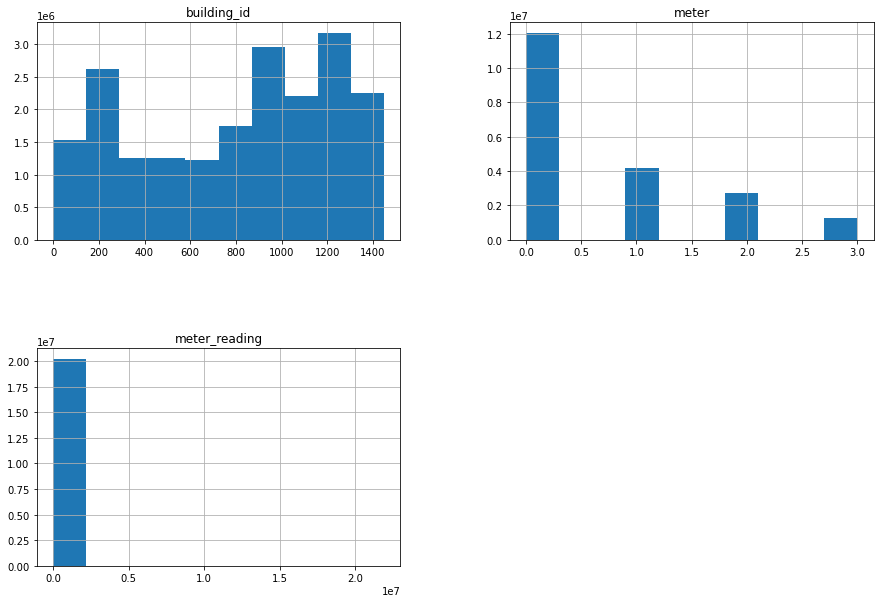

In [34]:
corrected_meter_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

* there are a lot more readings from the meter 0, which is for electricity
* The meter_reading histogram and the description table with simple statistics clearly shows there is an outlier. The max for the meter reading is 21904700.0!!!
* I need to investigate this issue with the meter further. 
    * what is a meter reading that makes sense?
    * What buildings are recording that crazy value for the meter readings? what type of meters are these? I will investigate this further later in the notebook

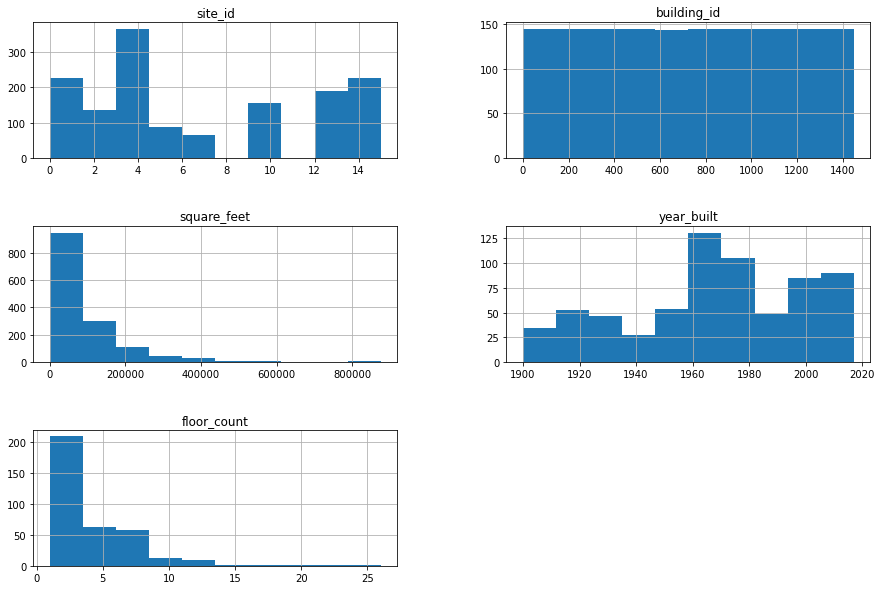

In [35]:
building_metadata.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

The building characteristics dataset looks okay to me. 

* There are some outliers with bigger buildings. It may be interesting to grab more details about these buildings. What type of buildings are these? Do they consume a lot of energy?
* Most of the buildings were built after 1960. How related is energy consumption to the year that it was built? It should be noted that we are missing half of the year_built values. 
* Also, it should be noted that we are also missing 75% of the floor_count values.
* Another thing that could be checked as I go through this project is whether floor count and square_feet correlate. If so, floor_count could be removed since it is missing a lot of the data and square_feet could be enough to capture the influence of building size on energy consumption.

<AxesSubplot:xlabel='square_feet', ylabel='floor_count'>

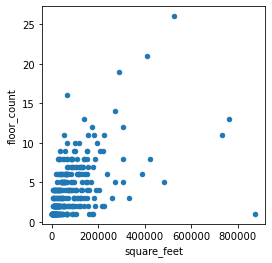

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
building_metadata.plot(x="square_feet", y='floor_count', kind="scatter", ax=ax)

They don't... 

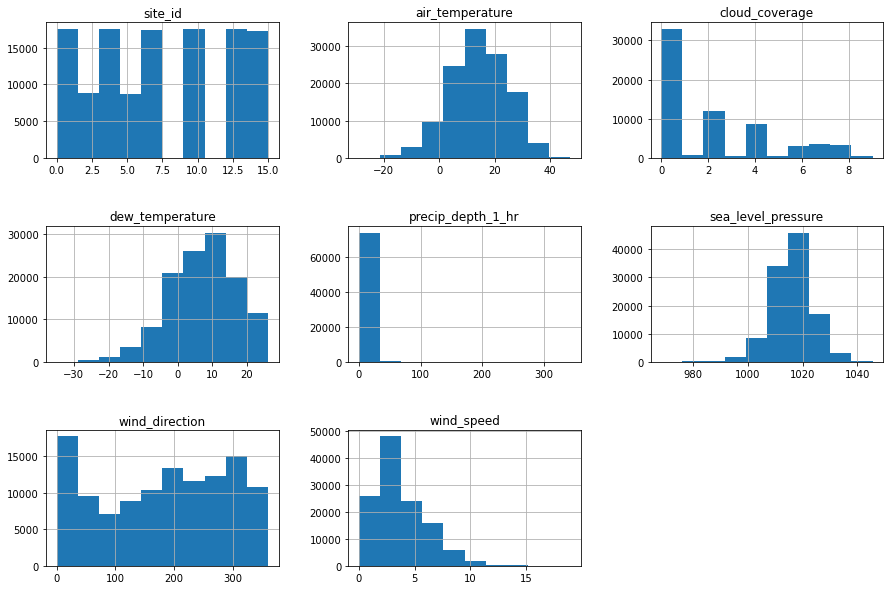

In [37]:
weather_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

#### 1.6.2.3 Assess Skewness in Numeric Data<a id='1.6.2.3_Assess_Skewness_in_Numeric_Data'></a>

One way to quantify skewness is with the use of the .skew() method in pandas. This can be done in addition to assessing skewness by viasualization. Below we see that meter_reading is highly skewed, but this can be modified by taking the log of the data.

In [38]:
corrected_meter_data['meter_reading'].skew(axis=0,skipna=True)

104.88999974187708

In [39]:
corrected_meter_data['meter_reading_log']=np.log(corrected_meter_data['meter_reading']+1)
corrected_meter_data.head()
corrected_meter_data['meter_reading_log'].skew(axis=0,skipna=True)

-0.22088759808467853

<AxesSubplot:>

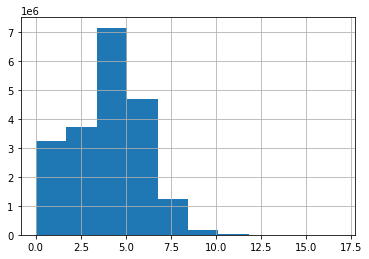

In [40]:
corrected_meter_data['meter_reading_log'].hist()

Below, we also assess the skewness of the weather data, and log transform those that are highly skewed, specifically **precip_depth_1**, **cloud_coverage**, and **wind_speed**.

In [41]:
weather_data.skew(axis = 0, skipna = True, numeric_only=True)

site_id                0.153288
air_temperature       -0.215038
cloud_coverage         1.035218
dew_temperature       -0.411905
precip_depth_1_hr     18.344856
sea_level_pressure    -0.397659
wind_direction        -0.189961
wind_speed             0.843280
dtype: float64

For the weather data, **precip_depth_1_hr** as observed is highly skewed. **cloud_coverage** and **wind_speed** are somewhat skewed. 

In [42]:
weather_data['precip_depth_1_hr_log']=np.log(weather_data['precip_depth_1_hr']+1)
weather_data['cloud_coverage_log']=np.log(weather_data['cloud_coverage']+1)
weather_data['wind_speed_log']=np.log(weather_data['wind_speed']+1)

In [43]:
weather_data.skew(axis=0,skipna=True,numeric_only=True)

site_id                   0.153288
air_temperature          -0.215038
cloud_coverage            1.035218
dew_temperature          -0.411905
precip_depth_1_hr        18.344856
sea_level_pressure       -0.397659
wind_direction           -0.189961
wind_speed                0.843280
precip_depth_1_hr_log     4.723353
cloud_coverage_log        0.391821
wind_speed_log           -0.809343
dtype: float64

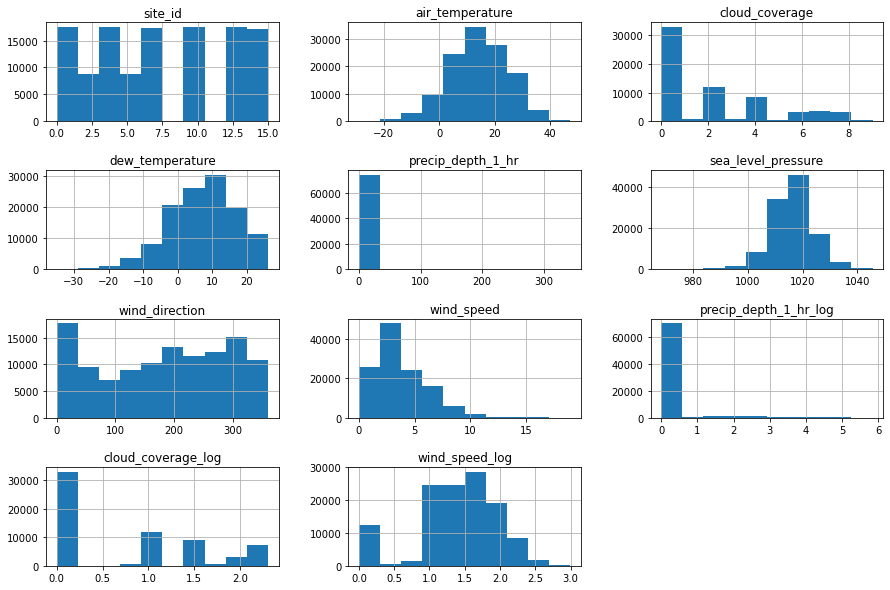

In [44]:
weather_data.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

**cloud_coverage** has a lot of 0.0 values. **precip_depth_1_hr_log** is still highly skewed. This needs a closer look

Next we asssess the skewness in the building characteristics data, and log transform those that are significantly skewed.

In [45]:
building_metadata.skew(axis=0,skipna=True,numeric_only=True)

site_id        0.403094
building_id    0.000000
square_feet    2.950772
year_built    -0.376338
floor_count    2.231123
dtype: float64

**square_feet** and **floor_count** are significantly skewed. Therefore, we will log transform them.

In [46]:
building_metadata['floor_count_log']=np.log(building_metadata['floor_count'])
building_metadata['square_feet_log']=np.log(building_metadata['square_feet'])
building_metadata.skew(axis=0,skipna=True,numeric_only=True)

site_id            0.403094
building_id        0.000000
square_feet        2.950772
year_built        -0.376338
floor_count        2.231123
floor_count_log    0.229718
square_feet_log   -0.685016
dtype: float64

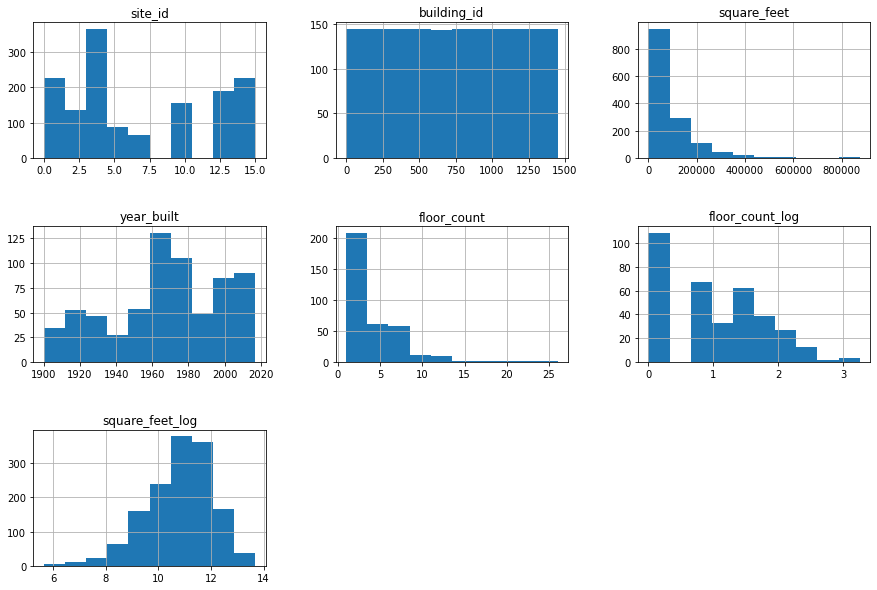

In [47]:
building_metadata.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

**floor_count** still has a lot of 0 values

## 1.7 Identifying Potential Outliers<a id='1.7_Identifying_Potential_Outliers'></a>

In section 1.6.2, I identified features that could potentially contain outliers. These features are:
   * meter_reading
   * precip_depth_1_hr
   
After log transformation, meter_reading looks okay. But still deserves a closer look because 2x10<sup>7</sup> is still very large energy consumption for an hour!

Precip_depth definitely needs a closer look. Even with the log transformation, it is sill highly skewed. When we look at the data, as a reminder, 40% are missing, and 55% are 0.0. only ~5% are greater than 0.0.
    
Other features that are skewed and worth looking at are:
   * square_feet
   * floor_count
   * cloud_coverage
   * wind_speed

After log transformation, square_feet looks okay. Floor count should be okay. While we have a lot of 0.0 values (log of 1-floor buildings), to me it makes sense that buildings tend to have 1 floor, and bigger buildings are towards the tail end of the distribution. This is also missing a lot of the data (75%). Could the skewness be due to so much data missing?

Cloud_coverage and wind_speed were skewed. The log transformation fixed wind_speed. However, cloud coverage still seems somewhat skewed, with a lot of 0.0 values. 

### 1.7.1 Potential Outliers in meter_reading<a id='1.7.1_Potential_Outliers_in_meter_reading'></a>

My goals here are to identify the buildings with more than exp(10) energy consumption, the outliers when log transformation is applied on the meter_readings data. Then I want to check if there is a commonality in this subset of the data. 
- Is this energy consumption related to large buildings? 
- the type of building? 
- the type of meter reading? 
- specific weather conditions? (too cold or too hot)
    - are these recordings mostly from the summer/winter?

first, I want to turn the timestamp into a datetime object so I can extract the date from it and use this for analysis

In [48]:
corrected_meter_data['timestamp']=pd.to_datetime(corrected_meter_data['timestamp'],format='%Y-%m-%d %H:%M:%S')
corrected_meter_data['month']=corrected_meter_data['timestamp'].dt.month
corrected_meter_data['day']=corrected_meter_data['timestamp'].dt.day
corrected_meter_data['dayofweek']=corrected_meter_data['timestamp'].dt.dayofweek
corrected_meter_data['hour']=corrected_meter_data['timestamp'].dt.hour
corrected_meter_data.head()

,building_id,meter,timestamp,meter_reading,meter_reading_log,month,day,dayofweek,hour
0,0,0,2016-01-01,0.0,0.0,1,1,4,0
1,1,0,2016-01-01,0.0,0.0,1,1,4,0
2,2,0,2016-01-01,0.0,0.0,1,1,4,0
3,3,0,2016-01-01,0.0,0.0,1,1,4,0
4,4,0,2016-01-01,0.0,0.0,1,1,4,0


In [49]:
corrected_meter_data.dtypes

building_id                   int64
meter                         int64
timestamp            datetime64[ns]
meter_reading               float64
meter_reading_log           float64
month                         int64
day                           int64
dayofweek                     int64
hour                          int64
dtype: object

Here I am starting out by looking at the buildings reporting log(meter_readings) > 10.  There are 26 unique buildings.

In [50]:
selected_buildings=corrected_meter_data[corrected_meter_data['meter_reading_log']>10]\
.sort_values(by='meter_reading',ascending=False)['building_id'].unique()
selected_buildings

array([1099,  778, 1021, 1168, 1197, 1088, 1159,  993, 1148,  954,   60,
       1154, 1156, 1107, 1140, 1284,  904, 1104, 1072, 1331, 1258, 1214,
        876, 1158,  776,  119], dtype=int64)

Next, I am grouping by building_id and meter to find out if there is a specific meter reporting these values.

In [51]:
corrected_meter_data[corrected_meter_data['meter_reading_log']>10].groupby(['building_id','meter','timestamp'])\
.max().sort_values(by=['meter_reading','building_id','meter'],ascending=False)

meter_reading  meter_reading_log  \
building_id meter timestamp                                               
1099        2     2016-06-13 09:00:00     21904700.0          16.902212   
                  2016-06-10 09:00:00     21889900.0          16.901536   
                  2016-06-10 08:00:00     21874500.0          16.900832   
                  2016-11-09 14:00:00     21847900.0          16.899615   
                  2016-06-13 08:00:00     21844500.0          16.899460   
...                                              ...                ...   
1107        2     2016-01-15 19:00:00        22031.2          10.000260   
1088        2     2016-02-12 20:00:00        22031.2          10.000260   
                  2016-04-08 15:00:00        22031.2          10.000260   
                  2016-04-12 14:00:00        22031.2          10.000260   
                  2016-11-28 11:00:00        22031.2          10.000260   

                                       month  day  dayofweek  hour  
building_id meter timestamp                                         
1099        2     2016-06-13 09:00:00      6   13          0     9  
                  2016-06-10 09:00:00      6   10          4     9  
                  2016-06-10 08:00:00      6   10          4     8  
                  2016-11-09 14:00:00     11    9          2    14  
                  2016-06-13 08:00:00      6   13          0     8  
...                                      ...  ...        ...   ...  
1107        2     2016-01-15 19:00:00      1   15          4    19  
1088        2     2016-02-12 20:00:00      2   12          4    20  
                  2016-04-08 15:00:00      4    8          4    15  
                  2016-04-12 14:00:00      4   12          1    14  
                  2016-11-28 11:00:00     11   28          0    11  

[37044 rows x 6 columns]

Is there a specific meter reporting these numbers? No, all types of meters are included. Although, when the readings are summed or when we pick the maximum meter reading, most values come from meter 2, which corresponds to hot water.

In [52]:
corrected_meter_data[corrected_meter_data['meter_reading_log']>10]\
.sort_values(by='meter_reading',ascending=False)['meter'].unique()

array([2, 1, 3, 0], dtype=int64)

do these buildings have any specific features?

Is the large energy use due to a specific building type or size? 

In terms of the type of building, not necessarily. While most are office, education, and services, and entertainment, previously we saw that most buildings fall into these categories anyways.

In [53]:
#select meter readings with a log(meter_reading) greater than 10, group them by building_id and take the maximum value,
#then reset the index and grab only the building_id and meter_reading columns
meter_reading_by_building=corrected_meter_data[corrected_meter_data['meter_reading_log']>10]\
.groupby(['building_id']).max().reset_index()[['building_id','meter_reading']]

#grab the buildings from the building metadata that have a meter_reading_log > 10 and merge this with the meter_reading 
#data from above to have building characteristics in the table as well.
high_consumption_buildings=building_metadata.loc[building_metadata['building_id'].isin(selected_buildings)]\
.merge(meter_reading_by_building,on='building_id')

#sort values by meter_reading and take the log, then sort by the size of the building
high_consumption_buildings.sort_values('meter_reading',ascending=False)
high_consumption_buildings['max_meter_reading_log']=np.log(high_consumption_buildings['meter_reading'])
high_consumption_buildings.sort_values('square_feet',ascending=False)

,site_id,building_id,primary_use,square_feet,year_built,floor_count,floor_count_log,square_feet_log,meter_reading,max_meter_reading_log
15,13,1148,Office,861524,NaN,NaN,NaN,13.666458,8.074220e+04,11.299017
19,13,1159,Office,671507,NaN,NaN,NaN,13.417280,1.006200e+05,11.519106
20,13,1168,Office,577101,NaN,NaN,NaN,13.265773,1.316250e+05,11.787712
24,14,1284,Education,442438,NaN,NaN,NaN,13.000056,3.179900e+04,10.367190
7,9,993,Education,428647,NaN,NaN,NaN,12.968389,8.791945e+04,11.384176
11,13,1099,Education,332884,NaN,NaN,NaN,12.715549,2.190470e+07,16.902212
6,9,954,Education,305224,NaN,NaN,NaN,12.628801,8.060074e+04,11.297263
9,13,1072,Healthcare,305000,NaN,NaN,NaN,12.628067,2.818950e+04,10.246705
18,13,1158,Public services,294812,NaN,NaN,NaN,12.594093,2.423750e+04,10.095656
10,13,1088,Education,287594,NaN,NaN,NaN,12.569305,1.045312e+05,11.557241


building 1099 looks like a very extreme outlier... it is the only log transformed meter reading that is higher than 16. The rest are all below 12.

In terms of the size of the building, I am looking at a correlation between the max of energy consumption reported by the meter readings and the size of the building, and there is no strong correlation. I am excluding building 1099 because its very high value didn't allow for clearly plotting the data.

<AxesSubplot:xlabel='square_feet', ylabel='meter_reading'>

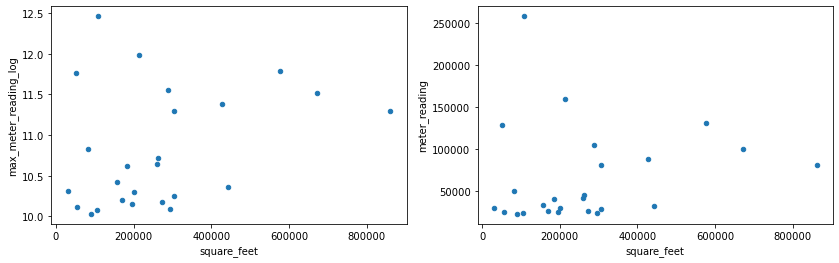

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
high_consumption_buildings[high_consumption_buildings['building_id'] != 1099]\
.plot(x="square_feet", y='max_meter_reading_log', kind="scatter", ax=ax[0])

high_consumption_buildings[high_consumption_buildings['building_id'] != 1099]\
.plot(x="square_feet", y='meter_reading', kind="scatter", ax=ax[1])

Next, I am interested in looking at the extremes. First, the building '1088', which is an education-type building, reports just above more than exp(10) of the energy consumption. What I am wondering is, is this some sort of spike in the meter readings, or is it more continous? It does seem to be continous. On November 28th, between the hours 6 am and 5 pm, the building used ~ 20,000 kWh per hour of energy in hot water. Maybe it was very cold on this day. 

In [55]:
building_1088=corrected_meter_data[(corrected_meter_data['building_id']==1088)]
building_1099=corrected_meter_data[(corrected_meter_data['building_id']==1099)]

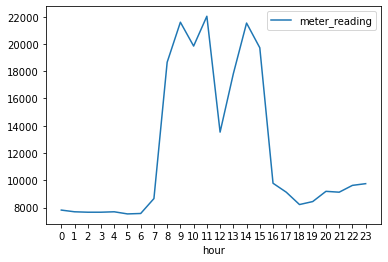

In [56]:
building_1088[(building_1088['meter']==2) & ((building_1088['timestamp'] >= '2016-11-28 00:00:00') \
                                             & (building_1088['timestamp'] < '2016-11-29 00:00:00'))]\
                                            .plot( 'hour' , 'meter_reading' )
#plt.xticks(rotation=70);
plt.xticks(np.arange(0, 24, 1.0));

Here we are checking the weather. It was quite chilly. ~ 44 degrees fahrenheit in the morning, then ~ 50 in the evening. It was windier than average.

In [57]:
weather_data[(weather_data['site_id']==13) & ((weather_data['timestamp']>='2016-11-28 06:00:00') \
                                              & (weather_data['timestamp']<='2016-11-28 17:00:00'))]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,precip_depth_1_hr_log,cloud_coverage_log,wind_speed_log
121733,13,2016-11-28 06:00:00,7.2,8.0,5.6,3.0,990.5,130.0,9.3,1.386294,2.197225,2.332144
121734,13,2016-11-28 07:00:00,7.2,NaN,5.6,NaN,989.1,130.0,10.3,NaN,NaN,2.424803
121735,13,2016-11-28 08:00:00,7.8,NaN,6.1,0.0,988.2,130.0,7.2,0.000000,NaN,2.104134
121736,13,2016-11-28 09:00:00,8.3,NaN,6.7,0.0,987.0,140.0,9.8,0.000000,NaN,2.379546
121737,13,2016-11-28 10:00:00,9.4,NaN,7.8,8.0,986.1,150.0,8.2,2.197225,NaN,2.219203
121738,13,2016-11-28 11:00:00,10.0,NaN,7.8,5.0,985.5,160.0,8.2,1.791759,NaN,2.219203
121739,13,2016-11-28 12:00:00,10.6,8.0,7.8,NaN,985.0,160.0,9.8,NaN,2.197225,2.379546
121740,13,2016-11-28 13:00:00,10.6,NaN,7.2,0.0,984.9,160.0,7.2,0.000000,NaN,2.104134
121741,13,2016-11-28 14:00:00,11.1,NaN,7.2,0.0,984.7,170.0,7.2,0.000000,NaN,2.104134
121742,13,2016-11-28 15:00:00,11.1,NaN,7.8,0.0,984.6,160.0,8.2,0.000000,NaN,2.219203


Select building 1099 and look at its energy consumption with meter 2, which corresponds to hot water

<AxesSubplot:xlabel='timestamp'>

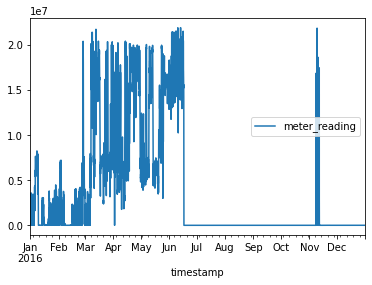

In [58]:
building_1099[building_1099['meter']==2].plot( 'timestamp' , 'meter_reading' )

This energy consumption is simply too high. So it will not be considered in the modeling.

Besides looking at the data manually.. are there any other ways of looking for outliers? This is a lot of data. How could I go through the data quickly to identify outliers? Here I have only looked at the meter reading throughout the day. Will I find any outliers if I do a greater range? if I look at the entire year for each building, for each meter? Maybe the modelling will tell?

### 1.7.2 Potential Outliers in precip_depth_1_hr<a id='1.7.2_Potential_Outliers_in_precip_depth_1_hr'></a>

In [53]:
weather_data['timestamp']=pd.to_datetime(weather_data['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [54]:
weather_data.dtypes

site_id                           int64
timestamp                datetime64[ns]
air_temperature                 float64
cloud_coverage                  float64
dew_temperature                 float64
precip_depth_1_hr               float64
sea_level_pressure              float64
wind_direction                  float64
wind_speed                      float64
precip_depth_1_hr_log           float64
cloud_coverage_log              float64
wind_speed_log                  float64
dtype: object

<AxesSubplot:>

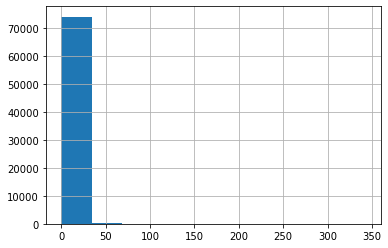

In [55]:
weather_data['precip_depth_1_hr'].hist()

40% of the precip_depth_1_hr are missing. 

what percentage have a value of 0.0, which would correspond to no precipitation?

In [56]:
100*len(weather_data[weather_data['precip_depth_1_hr']==0.0])/len(weather_data)

57.17017364657814

In addition to 40% of the data missing, 55.7 % have a value of 0.0

In [57]:
100*len(weather_data[weather_data['precip_depth_1_hr']>0.0])/len(weather_data)

3.803064351378958

4% of the data have a precipitation greater than 0.0.

according to USGS (U.S. Geological Service): "Violent shower: Greater than 50 mm per hour.""

In [58]:
extreme_precip=weather_data[weather_data['precip_depth_1_hr']>=50]

<AxesSubplot:>

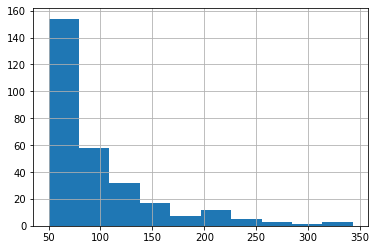

In [59]:
extreme_precip['precip_depth_1_hr'].hist()

How much did it rain in each site_id?

In [60]:
weather_data.groupby('site_id')['precip_depth_1_hr'].sum().sort_values()

site_id
1         0.0
5         0.0
12        0.0
2      1499.0
4      2271.0
10     4453.0
3      6690.0
14     6976.0
9      7006.0
15     7154.0
6      7469.0
7      8297.0
13     8497.0
0     12569.0
Name: precip_depth_1_hr, dtype: float64

It rained the most in site 0. Site_id's 1, 5, and 12 have null values.

<Figure size 432x288 with 0 Axes>

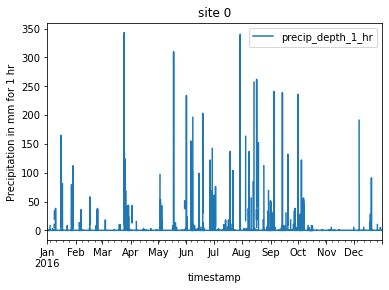

<Figure size 432x288 with 0 Axes>

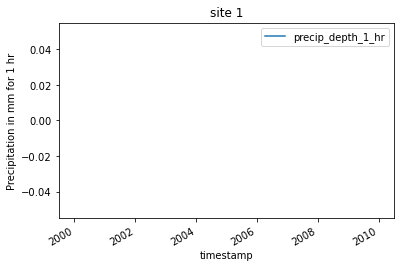

<Figure size 432x288 with 0 Axes>

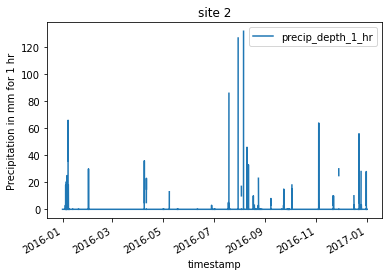

<Figure size 432x288 with 0 Axes>

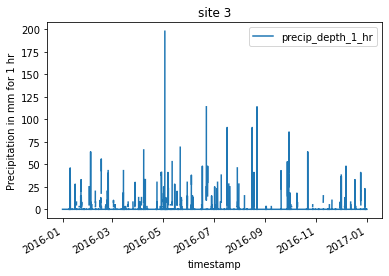

<Figure size 432x288 with 0 Axes>

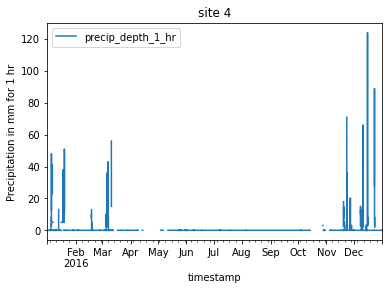

<Figure size 432x288 with 0 Axes>

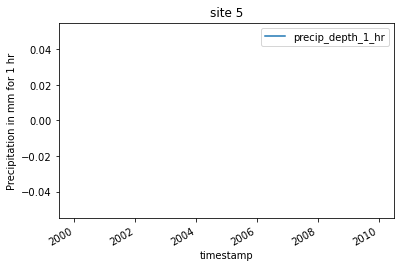

<Figure size 432x288 with 0 Axes>

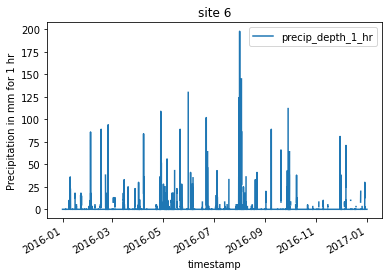

<Figure size 432x288 with 0 Axes>

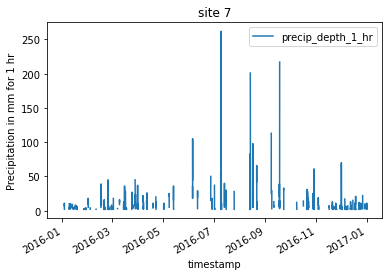

<Figure size 432x288 with 0 Axes>

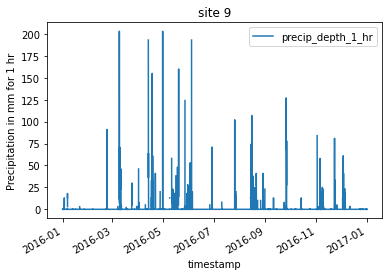

<Figure size 432x288 with 0 Axes>

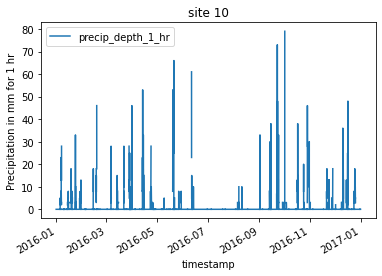

<Figure size 432x288 with 0 Axes>

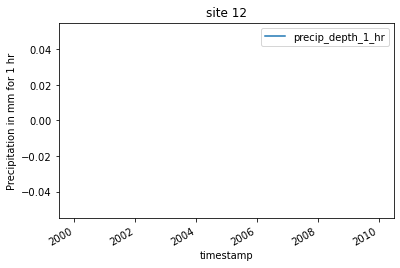

<Figure size 432x288 with 0 Axes>

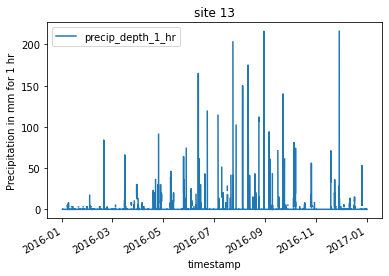

<Figure size 432x288 with 0 Axes>

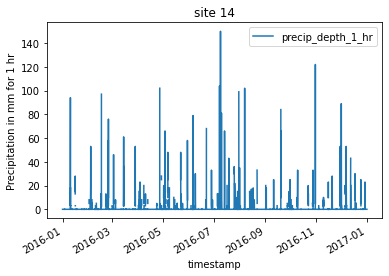

<Figure size 432x288 with 0 Axes>

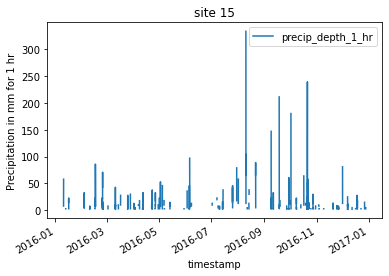

In [61]:
#plotting precipitation during the year for each site
site_ids=list(weather_data['site_id'].unique())
for site in site_ids:
    plt.figure();
    weather_data[weather_data['site_id']==site].plot('timestamp','precip_depth_1_hr');
    plt.title('site %s' %(site));
    plt.ylabel('Precipitation in mm for 1 hr');
    plt.show();

When I look at the data, this way, a lot of the sites have moments when precipitation is greater than 200. So these large values seem to be common. Over time, one can realize that precipitation lasts in short bursts of time. 

<Figure size 432x288 with 0 Axes>

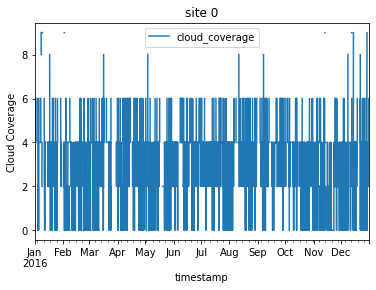

<Figure size 432x288 with 0 Axes>

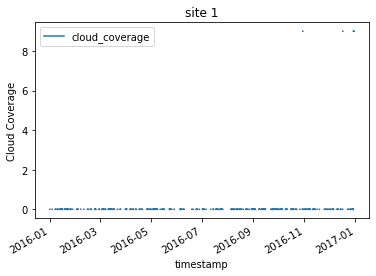

<Figure size 432x288 with 0 Axes>

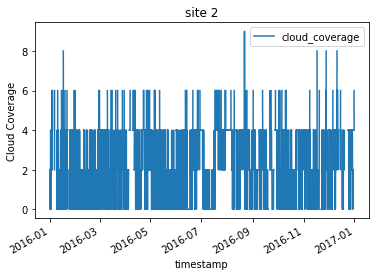

<Figure size 432x288 with 0 Axes>

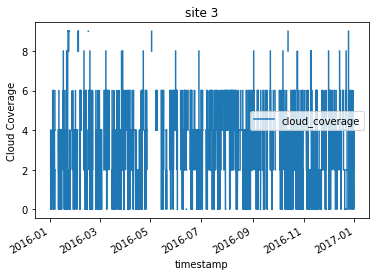

<Figure size 432x288 with 0 Axes>

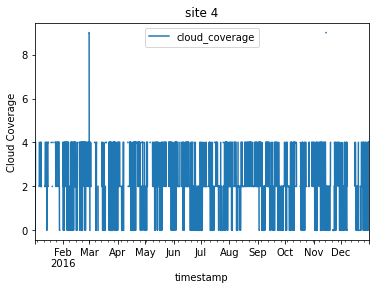

<Figure size 432x288 with 0 Axes>

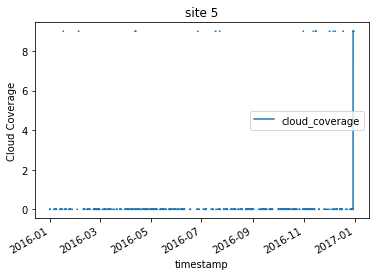

<Figure size 432x288 with 0 Axes>

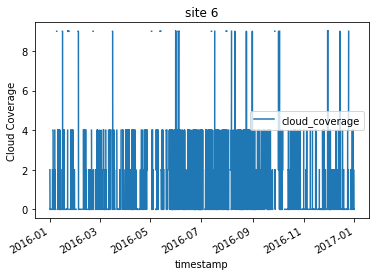

<Figure size 432x288 with 0 Axes>

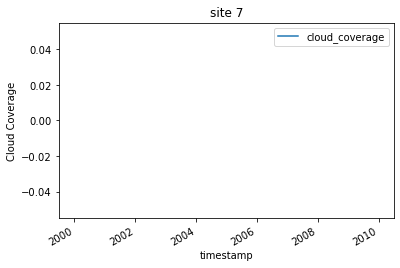

<Figure size 432x288 with 0 Axes>

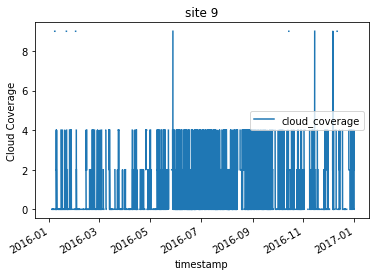

<Figure size 432x288 with 0 Axes>

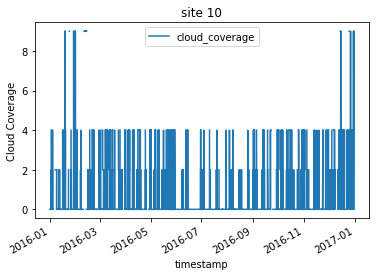

<Figure size 432x288 with 0 Axes>

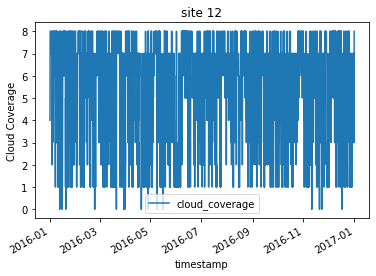

<Figure size 432x288 with 0 Axes>

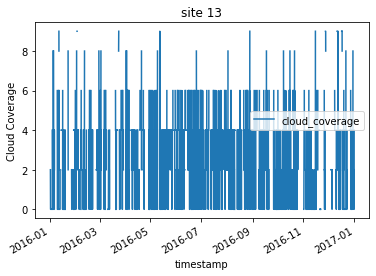

<Figure size 432x288 with 0 Axes>

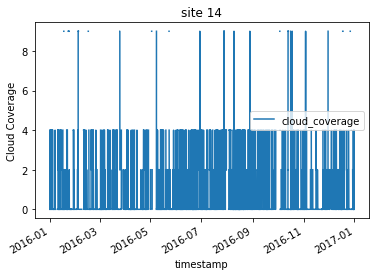

<Figure size 432x288 with 0 Axes>

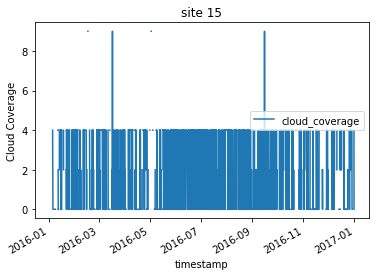

In [62]:
#plotting cloud coverage during the year for each site
site_ids=list(weather_data['site_id'].unique())
for site in site_ids:
    plt.figure();
    weather_data[weather_data['site_id']==site].plot('timestamp','cloud_coverage');
    plt.title('site %s' %(site));
    plt.ylabel('Cloud Coverage');
    plt.show();

- Does cloud_coverage have some outliers? They seem to appear in a lot of the sites. Or maybe they're not really outliers... clouds do tend to be quite instantaneous when they cast a shadow...
- Some of them have no cloud coverage. specifically site 1 (although some outliers?), and 4, 7 and 11 (have no data!).
- The next steps are to figure out what to do with missing data. Fill in with mean? median? What is the appropriate way to assess this?
- Note that cloud_coverage and floor_count are missing 50% and 75% of the data, respectively.
- For the greatly skewed data, replace with categorical values?

## 1.8 Aligning Time Zones<a id='1.8_Aligning_Time_Zones'></a>

During exploratory data analysis, I noticed some odd patterns. For example, electricity usage was higher during the night than during the day, which did not make sense. When I looked this up on the kaggle discussion, a competitor brought to everyone's attention that the weather data was in UTC, while the meter readings were in local time. This meant that the timestamps in the weather data had to be shifted to the local times that would correspond to the meter readings. Here, I will do some of that exploratory data analysis, as well as correct for the time zones in the weather data. 

### 1.8.1 Merging the data<a id='1.8.1_Merging_the_data'></a>

First, we merge meter readings with the data containing building characteristics. Prior to merging, save the corrected_meter_data.

In [63]:
corrected_meter_data.to_csv('../data/processed/corrected_meter_data.csv')

In [64]:
building_and_meter_data=corrected_meter_data.merge(building_metadata,on='building_id')
building_and_meter_data.to_csv('../data/processed/building_and_meter_data.csv')

In [70]:
print('building_and_meter_data contains {} rows'.format(building_and_meter_data.shape[0]))

building_and_meter_data contains 20216100 rows


Next, merge weather data, but first check any additional data we may be missing

In [71]:
total_site_ids=len(weather_data.site_id.unique())
ideal_number_of_rows = total_site_ids * 366 * 24
actual_number_of_rows = weather_data.shape[0]
missing_percentage=((ideal_number_of_rows-actual_number_of_rows)/(ideal_number_of_rows))*100
print('weather data is missing an additional {:.2f}% of all the data it should have \
for every hour of every day in 2016'.format(missing_percentage))

weather data is missing an additional 0.49% of all the data it should have for every hour of every day in 2016


Am I going to fill in for every date? By merging, I am leaving out those meter readings without corresponding weather data. Would this be okay? we are leaving out 0.5% of the data. I think this is okay. In the future, when I try to fill in by doing the rolling average, I have to also keep in mind that the rolling average will leave out those "missing dates/hours"

In [73]:
data=building_and_meter_data.merge(weather_data, on=['timestamp','site_id'])

In [76]:
print('merged dataset contains {} rows, which is {:.1f}% of the original data without the weather information.'\
      .format((data.shape[0]), ((data.shape[0])/building_and_meter_data.shape[0])*100))

merged dataset contains 20125605 rows, which is 99.6% of the original data without the weather information.


In [77]:
data.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading',
       'meter_reading_log', 'month', 'day', 'dayofweek', 'hour', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'floor_count_log', 'square_feet_log', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed',
       'precip_depth_1_hr_log', 'cloud_coverage_log', 'wind_speed_log'],
      dtype='object')

### 1.8.2 Energy usage vs. air temperature<a id='1.8.2_Energy_usage_vs_air_temperature'></a>

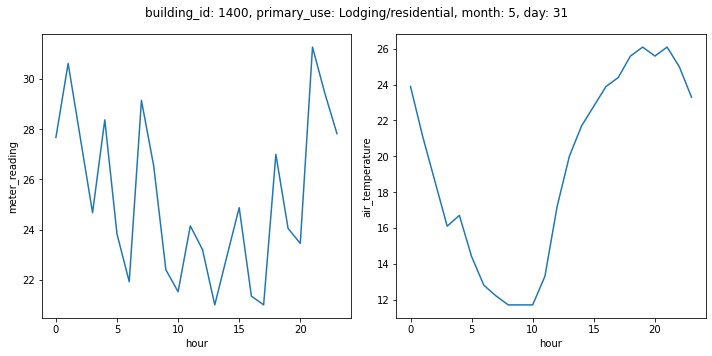

In [78]:
#select building, month, day, and meter reading
building_id=1400
month=5
day=31
meter=0

#set up conditions
by_building_id=(data['building_id']==building_id)
by_month=(data['month']==month)
by_meter=(data['meter']==meter)
by_day=(data['day']==day)

#slice the 'data' dataframe 
energy_usage=data[by_building_id & by_month & by_meter & by_day]
features=['meter_reading','air_temperature']

#plot the energy usage and air temperature
fig, ax = plt.subplots(1,len(features),figsize=(10,5))
for i in range(len(features)):
    ax[i].plot(energy_usage.hour,energy_usage[features[i]]);
    ax[i].set_xlabel('hour')
    ax[i].set_ylabel(features[i])
    plt.suptitle('building_id: ' + str(building_id) + ',' 
          +' primary_use: ' + energy_usage['primary_use'].unique()[0] + ',' 
          + ' month: ' + str(month) + ',' 
          + ' day: ' + str(day));
plt.tight_layout()

The electricity usage is highest at night... when everything is off. Is something off? Is it very cold at night? No it is not, it is pretty cool. There is a discussion on the kaggle competition website that the weather data is in UTC, while the meter readings are in local time. So this is something I have to fix.

### 1.8.3 Use external temperature data to shift time zones<a id='1.8.3_Use_external_temperature_data_to_shift_time_zones'></a>

#### Reduce weather data to the necessary temperature data 

In [79]:
# reduce to necessary columns
my_temp_data=weather_data[['site_id','timestamp','air_temperature']]

#reformat shape of the temp_data table
my_temp_data = pd.pivot_table(my_temp_data, values='air_temperature', columns=['site_id'],index=['timestamp'])

my_temp_data.head(3)

site_id,0,1,2,3,4,5,6,7,9,10,12,13,14,15
timestamp,,,,,,,,,,,,,,
2016-01-01 00:00:00,25.0,3.8,15.6,10.0,NaN,NaN,NaN,-1.8,NaN,NaN,1.9,-8.3,NaN,NaN
2016-01-01 01:00:00,24.4,3.7,13.9,9.4,9.4,5.0,10.0,-1.7,10.0,-10.6,1.6,-8.3,5.6,-1.0
2016-01-01 02:00:00,22.8,2.6,13.3,8.9,8.3,3.0,10.0,-2.7,10.0,-11.1,0.7,-7.8,5.6,-1.0


#### Load external temperature data

The external temperature data was obtained from here as adviced in the discussion threads: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

In [80]:
#load external data
external_temp_data=pd.read_csv('../data/external/temperature.csv')

# change the format of timestamp to datetime
external_temp_data['datetime']=pd.to_datetime(external_temp_data['datetime'],format='%Y-%m-%d %H:%M:%S')

# The original data is in Kelvin. Convert to celsius
external_temp_data.iloc[:,1:]=external_temp_data.iloc[:,1:]-273.15

# set the index to the timestamp
external_temp_data.set_index('datetime',inplace=True)

# obtain the data for 2016
external_temp_data=external_temp_data.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']

external_temp_data.head(5)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,-0.910000,2.443577,9.825494,3.696559,15.928882,16.014514,6.731597,14.862897,0.630187,-6.384279,...,5.210000,6.390000,-0.830000,4.057399,9.446000,13.600000,9.546000,16.670000,15.446000,13.580000
2016-01-01 01:00:00,-1.069921,1.560000,9.210000,2.780000,14.990000,14.870000,6.650000,14.120000,-1.180000,-8.260000,...,5.191341,6.268535,-0.849256,3.610000,9.339815,13.723079,9.495887,16.742789,15.475248,13.639121
2016-01-01 02:00:00,-1.800000,-0.633925,7.886930,-0.071831,8.414463,8.362194,1.023518,8.404841,-9.428313,-13.231024,...,3.272171,5.880000,-0.940000,2.982549,8.642000,14.530000,9.167000,17.220000,15.667000,14.550000
2016-01-01 03:00:00,-1.944679,0.380000,6.010000,-0.140000,11.120000,11.300000,4.940000,9.590000,-5.420000,-10.330000,...,4.690000,5.723939,-1.082154,2.720000,8.637270,14.355756,9.800323,16.709122,14.876739,14.485042
2016-01-01 04:00:00,-2.660000,0.332273,5.065575,-0.644554,10.692320,10.293253,3.931156,8.291419,-5.678187,-11.195920,...,4.010000,5.200000,-1.810000,2.530000,8.602000,13.060000,14.510000,12.910000,9.000000,13.090000


#### Create a correlation matrix between our temperature data and the external temperature data

<AxesSubplot:>

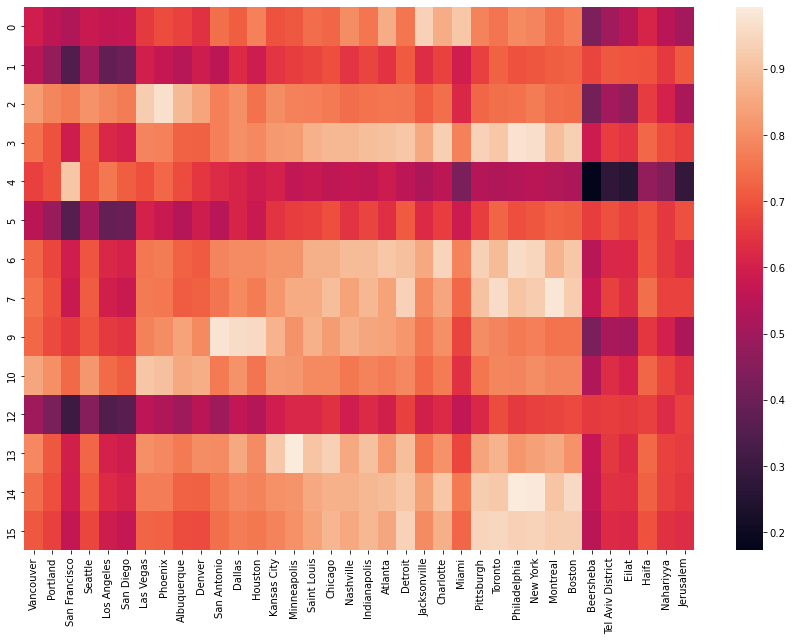

In [82]:
corr_matrix=pd.concat([external_temp_data, my_temp_data], axis=1, keys=['df1', 'df2']).corr().loc['df2', 'df1']
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix)

#### Identify corresponding sites with cities

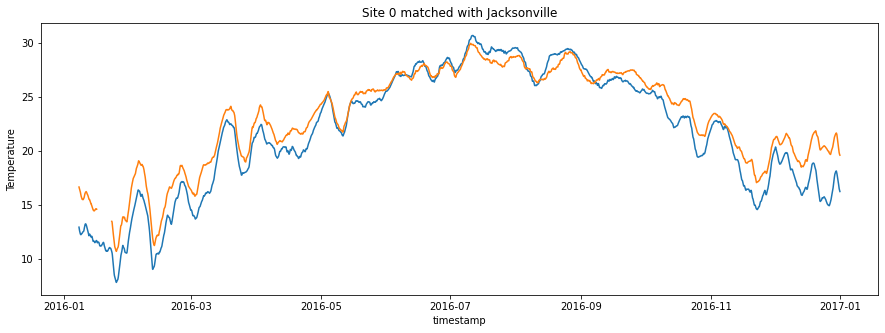

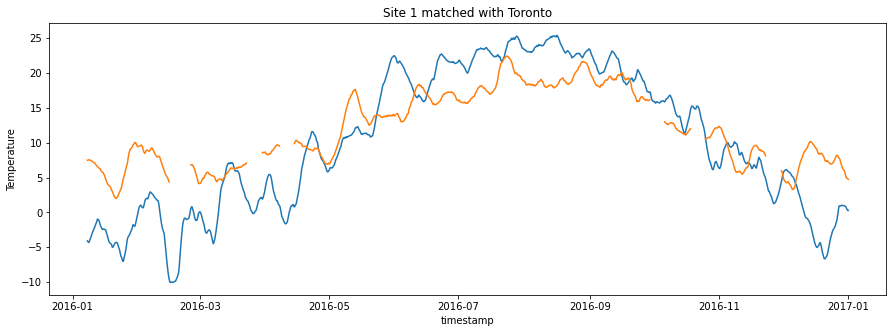

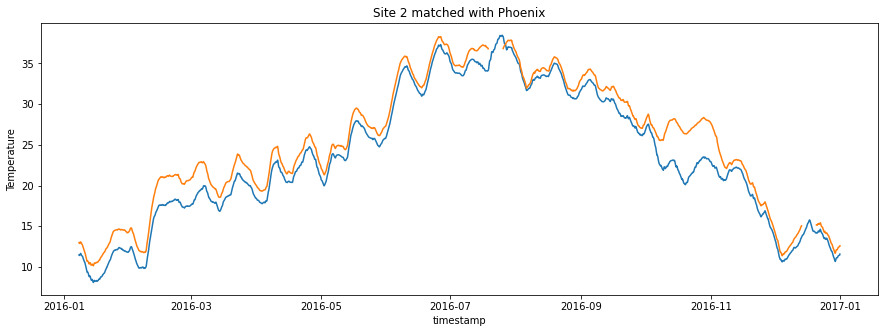

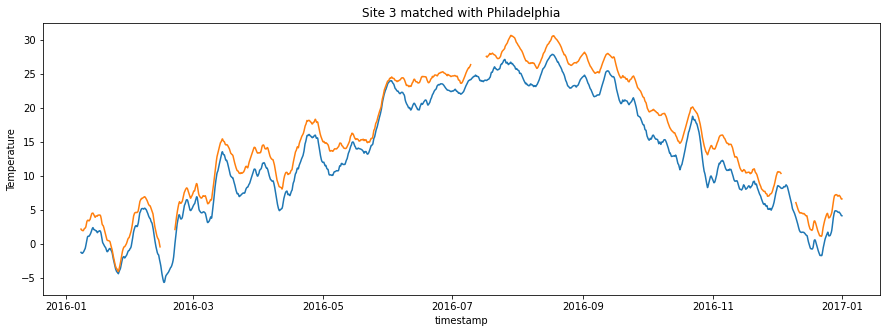

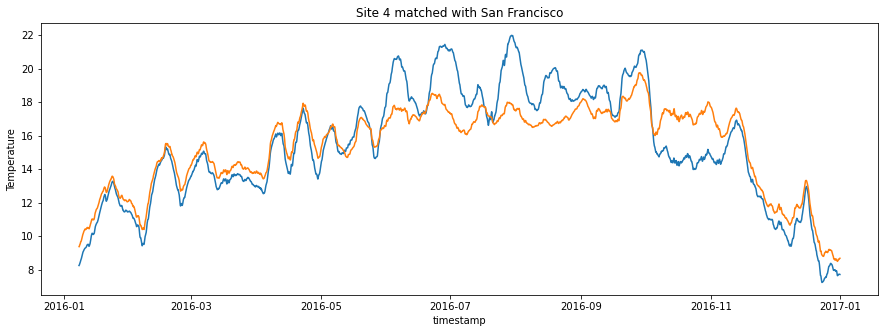

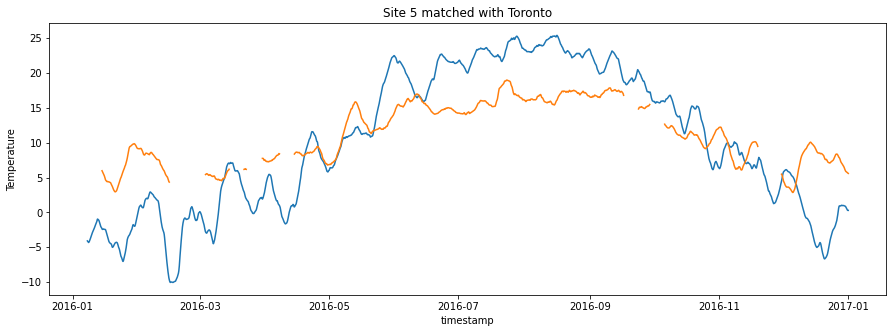

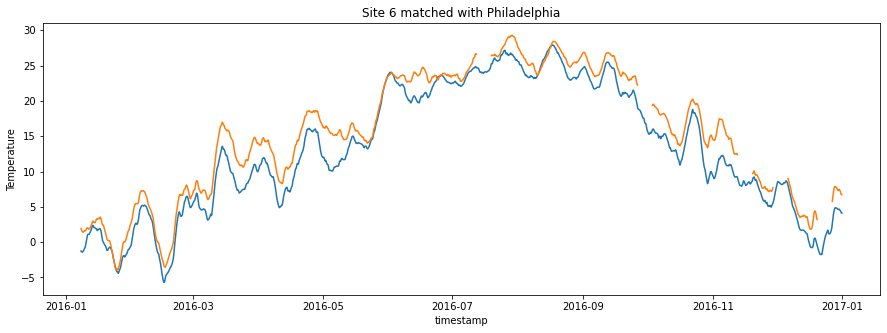

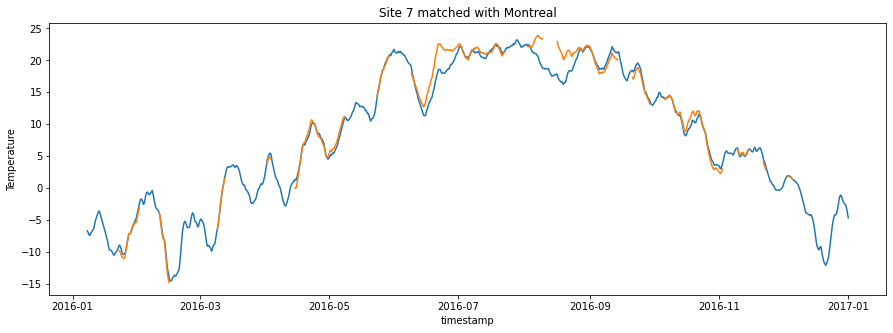

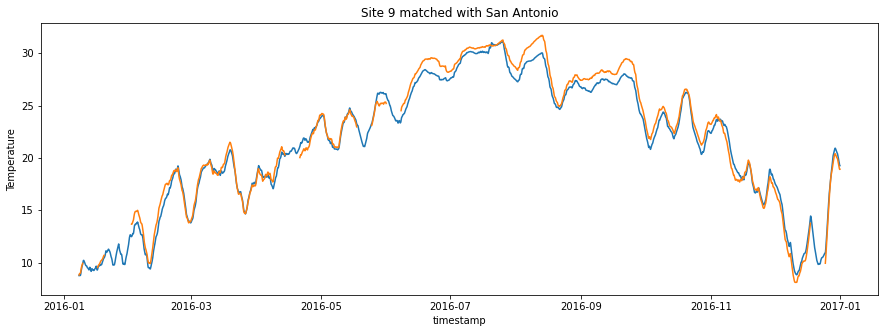

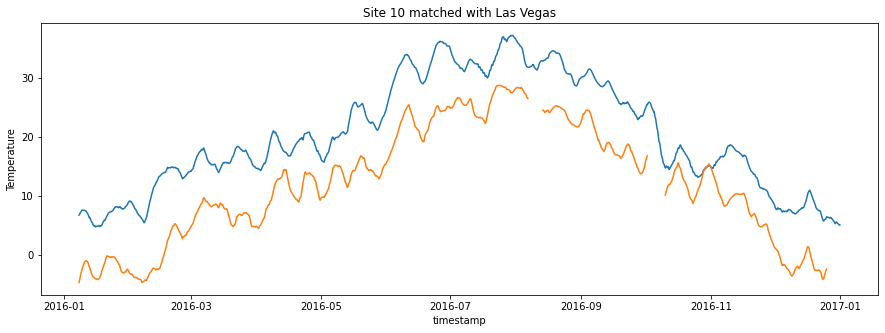

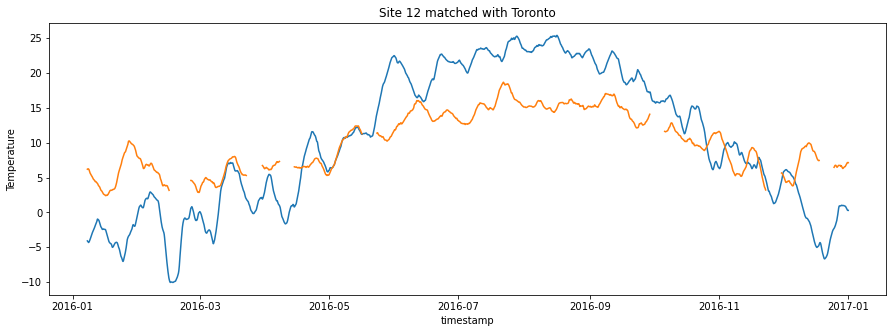

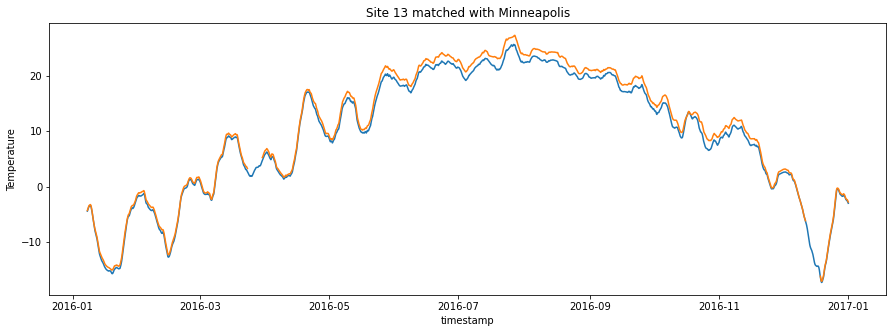

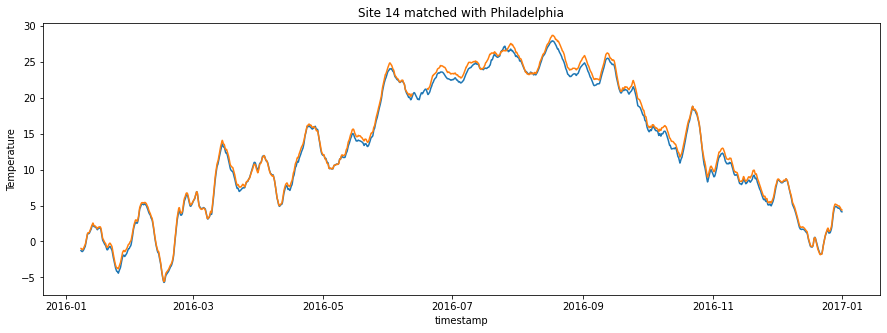

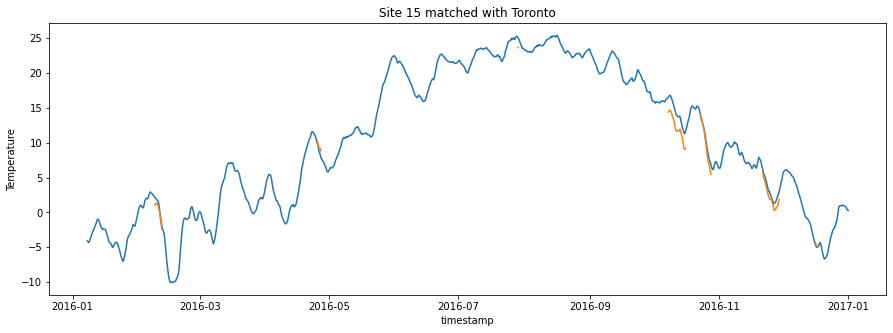

In [84]:
for i,v in corr_matrix.idxmax(axis=1).items():
    plt.subplots(figsize=(15,5))
    plt.plot(external_temp_data[v].rolling(168).mean())
    plt.plot(my_temp_data[i].rolling(168).mean())
    plt.title('Site %s matched with %s' %(str(i),v))
    plt.ylabel('Temperature')
    plt.xlabel('timestamp')
    plt.show()

After looking at these figures, we can be certain about the following matches for the purposes of shifting the UTC timezone in the weather data to local timezone:
- Site 0: Jacksonville: UTC - 5 hours
- Site 2: Pheonix: UTC - 8 hours
- Site 3: Philadelphia: UTC - 5 hours
- Site 4: San Francisco: UTC - 8 hours 
- Site 6: Philadelphia: UTC - 5 hours
- Site 7: Montreal: UTC - 5 hours
- Site 9: San Antonio: UTC - 6 hours
- Site 13: Minneapolis: UTC - 6 hours 
- Site 14: Philadelphia: UTC - 5 hours
- Site 15: Toronto: UTC - 5 hours

Sites 1, 5, 10, and 12 don't match very well. For these, I will look at other possible matches. 

In [85]:
for i in [1,5,10,12]:
    print(corr_matrix.loc[i].T.sort_values(ascending=False).head(5))

Toronto      0.722419
Boston       0.721281
Montreal     0.715906
Detroit      0.711356
Jerusalem    0.707286
Name: 1, dtype: float64
Toronto     0.725674
Montreal    0.721416
Boston      0.717019
Detroit     0.711194
New York    0.703224
Name: 5, dtype: float64
Las Vegas      0.911566
Phoenix        0.898756
Denver         0.865406
Albuquerque    0.850403
Vancouver      0.849120
Name: 10, dtype: float64
Toronto     0.686069
Boston      0.683238
Montreal    0.673645
New York    0.669255
Detroit     0.665699
Name: 12, dtype: float64


After looking at the various options above, I found Denver and Albuquerque to be better matches to site 10 (UTC - 7 hours). However, I am still uncertain about sites 1, 5, and 12.

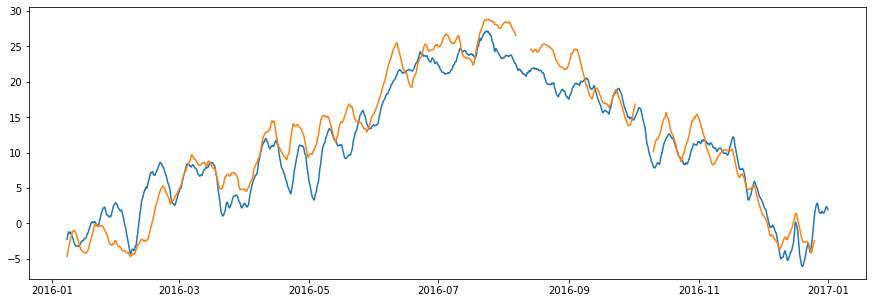

In [88]:
plt.subplots(figsize=(15,5))
plt.plot(external_temp_data['Denver'].rolling(168).mean())
plt.plot(my_temp_data[10].rolling(168).mean())
plt.show()

#### Shift UTC time in our weather data

In [91]:
from datetime import timedelta

skip = [1,5,12]
site_ids = my_temp_data.drop(skip,axis=1).columns
shift_by = dict(zip(site_ids,[5,8,5,8,5,5,6,7,6,5,5]))
for key, value in shift_by.items():
    timestamp = weather_data.loc[weather_data['site_id'] == key,'timestamp']
    weather_data.loc[weather_data['site_id'] == key,'timestamp'] = timestamp - timedelta(hours=value)
weather_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,precip_depth_1_hr_log,cloud_coverage_log,wind_speed_log
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.945910,0.000000
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,NaN,1020.2,70.0,1.5,NaN,NaN,0.916291
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,0.0,1.098612,0.000000
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,0.0,1.098612,0.000000
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,NaN,1020.0,250.0,2.6,NaN,1.098612,1.280934


#### Shift UTC time in our merged data

In [92]:
for key, value in shift_by.items():
    timestamp = data.loc[data['site_id'] == key,'timestamp']
    data.loc[data['site_id'] == key,'timestamp'] = timestamp - timedelta(hours=value)

In [94]:
#update the month, day, dayofweek, hour features. 

data['timestamp']=pd.to_datetime(data['timestamp'],format='%Y-%m-%d %H:%M:%S')
data['month']=data['timestamp'].dt.month
data['day']=data['timestamp'].dt.day
data['dayofweek']=data['timestamp'].dt.dayofweek
data['hour']=data['timestamp'].dt.hour

In [95]:
data.head()

,building_id,meter,timestamp,meter_reading,meter_reading_log,month,day,dayofweek,hour,site_id,...,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,precip_depth_1_hr_log,cloud_coverage_log,wind_speed_log
0,0,0,2015-12-31 19:00:00,0.0,0.0,12,31,3,19,0,...,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.94591,0.0
1,1,0,2015-12-31 19:00:00,0.0,0.0,12,31,3,19,0,...,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.94591,0.0
2,2,0,2015-12-31 19:00:00,0.0,0.0,12,31,3,19,0,...,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.94591,0.0
3,3,0,2015-12-31 19:00:00,0.0,0.0,12,31,3,19,0,...,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.94591,0.0
4,4,0,2015-12-31 19:00:00,0.0,0.0,12,31,3,19,0,...,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,1.94591,0.0


## 1.9 Saving Processed Data<a id='1.9_Saving_Processed_Data'></a>

In [96]:
data.to_csv('../data/processed/merged_data_clean.csv')

In [97]:
weather_data.to_csv('../data/processed/weather_data_clean.csv')

In [98]:
building_metadata.to_csv('../data/processed/building_metadata_clean.csv')